In [1]:
import pickle
from pathlib import Path
import os
import numpy as np
from itertools import chain
from nilearn import datasets
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
import xarray as xr
#import significantdigits as sd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap 
import scipy.stats



In [4]:
import sys
import platform

print("Python version:", sys.version)
print("Platform:", platform.system())
print("Executable:", sys.executable)

# Check if conda environment is active
print("Conda Environment:", os.environ.get("CONDA_DEFAULT_ENV"))
print("Numpy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)


Python version: 3.11.11 | packaged by conda-forge | (main, Dec  5 2024, 14:21:42) [Clang 18.1.8 ]
Platform: Darwin
Executable: /Users/vi/miniforge3/envs/jupyter_stats/bin/python
Conda Environment: jupyter_stats
Numpy version: 2.2.0
Matplotlib version: 3.9.3


In [4]:
!conda list


# packages in environment at /Users/vi/miniforge3/envs/halfpipe:
#
# Name                    Version                   Build  Channel
aiofiles                  23.2.1             pyhd8ed1ab_0    conda-forge
annexremote               1.2.1                      py_0    conda-forge
annotated-types           0.6.0              pyhd8ed1ab_0    conda-forge
ants                      2.5.3                h420ef59_0    conda-forge
anyio                     3.7.1              pyhd8ed1ab_0    conda-forge
aom                       3.7.1                h463b476_0    conda-forge
appnope                   0.1.4                    pypi_0    pypi
archspec                  0.2.3              pyhd8ed1ab_0    conda-forge
astor                     0.8.1              pyh9f0ad1d_0    conda-forge
asttokens                 2.4.1              pyhd8ed1ab_0    conda-forge
atk-1.0                   2.38.0               hcb7b3dd_1    conda-forge
atpublic                  4.0                      pypi_0    pypi
attr

### Seed Connectivity

In [62]:
seed_connectivity = pickle.load(open('data/subject_matrices.pkl', 'rb'))

In [3]:
colors = ["#C9182B","yellow","yellowgreen","green"]
values = np.array([0, 0.2, 0.5, 1])
cmap = LinearSegmentedColormap.from_list("gangchen", list(zip(values, colors)))


for pre_process in seed_connectivity['sub-9040'].keys():
    fig, axes = plt.subplots(ncols=4, sharex=True, figsize=(20, 5), constrained_layout=True)

    for num, sub in enumerate(seed_connectivity.keys()):
        input = np.array(seed_connectivity[sub][pre_process])
        # mask = ~np.isnan(input).any(axis=(1, 2))
        # input[mask] = -np.inf
        sigdigs = sd.significant_digits(input, reference=input.mean(axis=0), basis=10)
        # sigdigs[np.isclose(sigdigs, 15.214328120692226, rtol=1e-4)] = np.nan
        sigdigs[sigdigs >= 15] = np.nan #temporary fix to sigdigs not dealing with NaN

        if num != 3: sns.heatmap(sigdigs, cmap=cmap, ax=axes[num], vmax=15, vmin=-4, cbar=False)
        else: sns.heatmap(sigdigs, cmap=cmap, ax=axes[num], vmin=-4, vmax=15, cbar=True)

        axes[num].set_title(f"{sub}\n(mean = {np.nanmean(sigdigs):.2f})")

    plt.suptitle(f"{pre_process.split('.')[0]}")
    break

NameError: name 'LinearSegmentedColormap' is not defined

### fMRI Connectivity

In [2]:
data_fm20 = pickle.load(open('data/subject_matrices.pkl', 'rb'))
data_fm24 = pickle.load(open('subject_matrices_fmriprep24.pkl', 'rb'))

In [2]:
data = pickle.load(open('data/subject_matrices.pkl', 'rb'))

In [2]:
data2 = pickle.load(open('subject_matrices_fmriprep24.pkl', 'rb'))

In [5]:
del data["sub-01"]

In [3]:

subjects = sorted(data.keys())
pipelines = sorted(set(chain.from_iterable(d.keys() for d in data.values())))
iterations = min(len(b) for a in data.values() for b in a.values())
(k,) = set(
    chain.from_iterable(c.shape for a in data.values() for b in a.values() for c in b)
)

len(subjects), len(pipelines), iterations, k

(4, 14, 101, 400)

In [5]:

schaefer_atlas = datasets.fetch_atlas_schaefer_2018(
    n_rois=400, yeo_networks=7, resolution_mm=1
)
schaefer_atlas_labels = list(map(bytes.decode, schaefer_atlas["labels"]))

[get_dataset_dir] Dataset found in /Users/vi/nilearn_data/schaefer_2018


In [6]:
indices = np.tril_indices(k, -1)
labels = np.array(
    [
        f"{schaefer_atlas_labels[i]}, {schaefer_atlas_labels[j]}"
        for i, j in zip(*indices)
    ]
)
labels

array(['7Networks_LH_Vis_2, 7Networks_LH_Vis_1',
       '7Networks_LH_Vis_3, 7Networks_LH_Vis_1',
       '7Networks_LH_Vis_3, 7Networks_LH_Vis_2', ...,
       '7Networks_RH_Default_pCunPCC_9, 7Networks_RH_Default_pCunPCC_6',
       '7Networks_RH_Default_pCunPCC_9, 7Networks_RH_Default_pCunPCC_7',
       '7Networks_RH_Default_pCunPCC_9, 7Networks_RH_Default_pCunPCC_8'],
      shape=(79800,), dtype='<U76')

In [7]:
arrays = []

for subject in subjects:
    subject_arrays = []
    for pipeline in pipelines:
        array = np.dstack(data[subject][pipeline])[
            *indices, :iterations, np.newaxis, np.newaxis
        ]

        subject_arrays.append(array)
    subject_array = np.concatenate(subject_arrays, axis=2)
    arrays.append(subject_array)
array = np.concatenate(arrays, axis=3)
array.shape

(79800, 101, 14, 4)

### We create a xarray Dataset instance from our data that contains 

In [8]:
ds = xr.Dataset(
    {"functional_connectivity": (["cell", "iteration", "pipeline", "subject"], array)},
    coords=dict(
        cell=labels, iteration=range(iterations), pipeline=pipelines, subject=subjects
    ),
)
ds

<xarray.Dataset> Size: 4GB
Dimensions:                  (cell: 79800, iteration: 101, pipeline: 14,
                              subject: 4)
Coordinates:
  * cell                     (cell) <U76 24MB '7Networks_LH_Vis_2, 7Networks_...
  * iteration                (iteration) int64 808B 0 1 2 3 4 ... 97 98 99 100
  * pipeline                 (pipeline) <U24 1kB 'GSR' ... 'simpleScrubbingGSR'
  * subject                  (subject) <U9 144B 'sub-01' 'sub-09' ... 'sub-9040'
Data variables:
    functional_connectivity  (cell, iteration, pipeline, subject) float64 4GB ...

In [9]:
s = np.asarray(ds.functional_connectivity.std(axis=(1)))
mask = np.isnan(s).any(axis=(1, 2))
s[mask, :, :] = -np.inf
np.unravel_index(np.argmax(s), s.shape)

/Users/vi/miniforge3/envs/jupyter_stats/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


(np.int64(67469), np.int64(12), np.int64(2))

In [10]:
s[mask, :, :] = np.inf
s[s == 0] = np.inf
np.unravel_index(np.argmin(s), s.shape)

(np.int64(76560), np.int64(9), np.int64(3))

In [11]:
ds.functional_connectivity[22805, :, 2, 0]

<xarray.DataArray 'functional_connectivity' (iteration: 101)> Size: 808B
array([0.88287685, 0.88120853, 0.88385343, 0.88536411, 0.88004314,
       0.88043074, 0.89212167, 0.88567424, 0.88524684, 0.88624732,
       0.88277556, 0.88195371, 0.88457869, 0.88875866, 0.88704276,
       0.88570943, 0.88931044, 0.88119105, 0.8844883 , 0.88822146,
       0.88397728, 0.88003445, 0.885937  , 0.88952191, 0.88611412,
       0.87956451, 0.8852685 , 0.8829689 , 0.88426142, 0.87778759,
       0.89218931, 0.87808774, 0.88252975, 0.88378415, 0.88132377,
       0.88403505, 0.88048044, 0.88862499, 0.88371053, 0.88191145,
       0.88343493, 0.88501643, 0.88815118, 0.87699488, 0.880918  ,
       0.88844541, 0.88415557, 0.88530311, 0.88020542, 0.88708464,
       0.88008414, 0.88031037, 0.8841055 , 0.88405052, 0.88039273,
       0.87997322, 0.88111149, 0.88358197, 0.88384231, 0.8818972 ,
       0.88236452, 0.88280537, 0.88752154, 0.87362389, 0.88546613,
       0.88196331, 0.8795924 , 0.88493662, 0.88512323, 0.88522416,
       0.88077227, 0.88078281, 0.88997499, 0.8756903 , 0.88137803,
       0.88451282, 0.88559959, 0.88862232, 0.88197424, 0.88332495,
       0.8855965 , 0.88916779, 0.88467842, 0.88447201, 0.88045078,
       0.88650804, 0.88643231, 0.8844658 , 0.87381705, 0.87970497,
       0.88102513, 0.8880997 , 0.88641211, 0.88225073, 0.88169686,
       0.87922604, 0.88541291, 0.88144277, 0.87928147, 0.88929645,
       0.88285671])
Coordinates:
    cell       <U76 304B '7Networks_RH_Vis_15, 7Networks_LH_Vis_15'
  * iteration  (iteration) int64 808B 0 1 2 3 4 5 6 7 ... 94 95 96 97 98 99 100
    pipeline   <U24 96B 'icaAroma'
    subject    <U9 36B 'sub-01'

<Axes: ylabel='Count'>

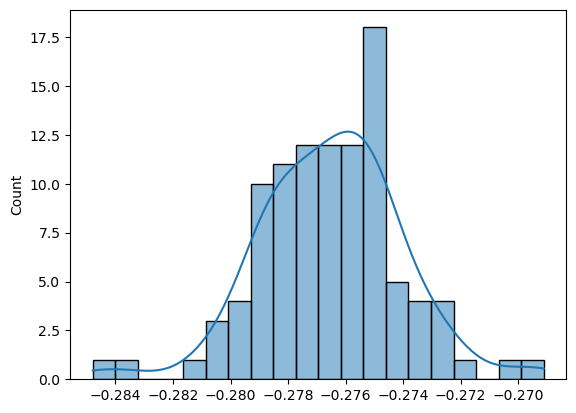

In [12]:

sns.histplot(
    ds.functional_connectivity[59334, :, 11, 0], bins=20, kde=True, stat="count"
)

In [21]:
from significantdigits import significant_digits

x = np.arctanh(ds.functional_connectivity[59334, :, 11, 0])
significant_digits(x, x.mean())

array(2.61097064)

In [29]:
x.mean()

<xarray.DataArray 'functional_connectivity' ()> Size: 8B
array(-0.41472443)
Coordinates:
    cell      <U76 304B '7Networks_RH_Cont_PFCl_5, 7Networks_RH_Cont_Temp_2'
    pipeline  <U10 40B 'TrueComb5'
    subject   <U9 36B 'sub-01'

In [20]:
x = ds.functional_connectivity[22805, :, 2, 0]
significant_digits(x, x.mean())

array(9.74880994)

In [22]:
x.mean().dtype

dtype('float64')

In [12]:
def make_sigdigs_vector(pipeline_index: int, subject_index: int = 0):
    #we need to feed x and the mean of x
    x = np.asarray(ds.functional_connectivity[:, :, pipeline_index, subject_index]).transpose()
    x.shape
    sigdigs = significant_digits(x, x.mean(axis=0), dtype=x.dtype, basis=10)
    sigdigs, sigdigs.shape
    invalid = np.isfinite(x).sum(axis=0) < 90
    sigdigs[invalid] = np.nan
    return sigdigs


def make_sigdigs_array(pipeline_index: int, subject_index: int = 0):
    array = np.full(fill_value=np.nan, shape=(k, k))
    array[*np.tril_indices(k, -1)] = make_sigdigs_vector(pipeline_index, subject_index)
    return array

def make_sigdigs_plot(title: str, ax: Axes, pipeline_index: int, subject_index: int = 0, cbar=True):
    array = make_sigdigs_array(pipeline_index, subject_index)
    sns.heatmap(array, vmax=4, vmin=-4, cmap="RdYlGn", ax=ax, cbar=cbar)  #"RdYlGn", cmap, vmax=4
    ax.set_title(f"{title}\n(mean = {np.nanmean(array):.2f})")

In [24]:
list(enumerate(pipelines))

[(0, 'FalseComb0'),
 (1, 'FalseComb1'),
 (2, 'FalseComb2'),
 (3, 'FalseComb3'),
 (4, 'FalseComb4'),
 (5, 'FalseComb5'),
 (6, 'TrueComb0'),
 (7, 'TrueComb1'),
 (8, 'TrueComb2'),
 (9, 'TrueComb3'),
 (10, 'TrueComb4'),
 (11, 'TrueComb5')]

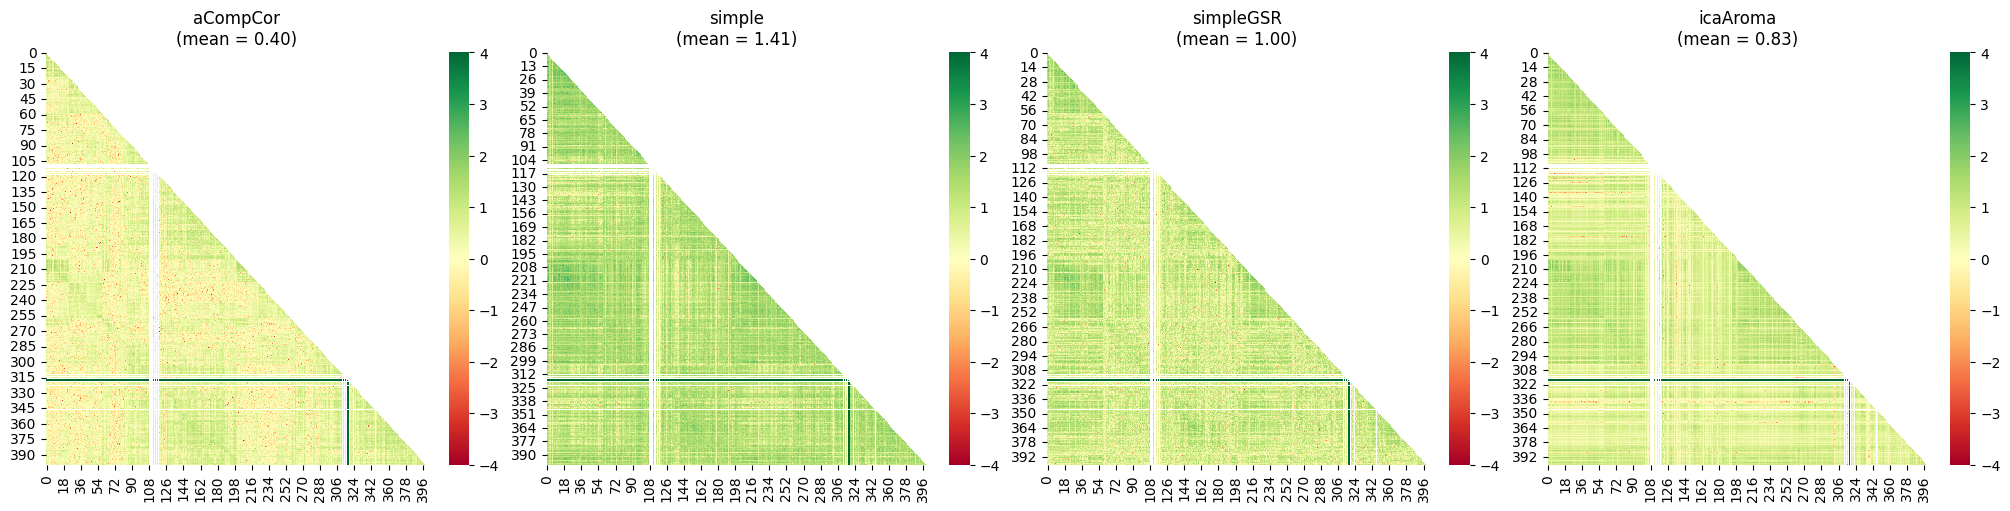

In [25]:

figure, axes_array = plt.subplots(
    ncols=4, sharex=True, figsize=(20, 5), constrained_layout=True
)

subject_index = 1
make_sigdigs_plot("aCompCor", axes_array[0], 1, subject_index)
make_sigdigs_plot("simple", axes_array[1], 3, subject_index)
make_sigdigs_plot("simpleGSR", axes_array[2], 4, subject_index)
make_sigdigs_plot("icaAroma", axes_array[3], 6, subject_index)

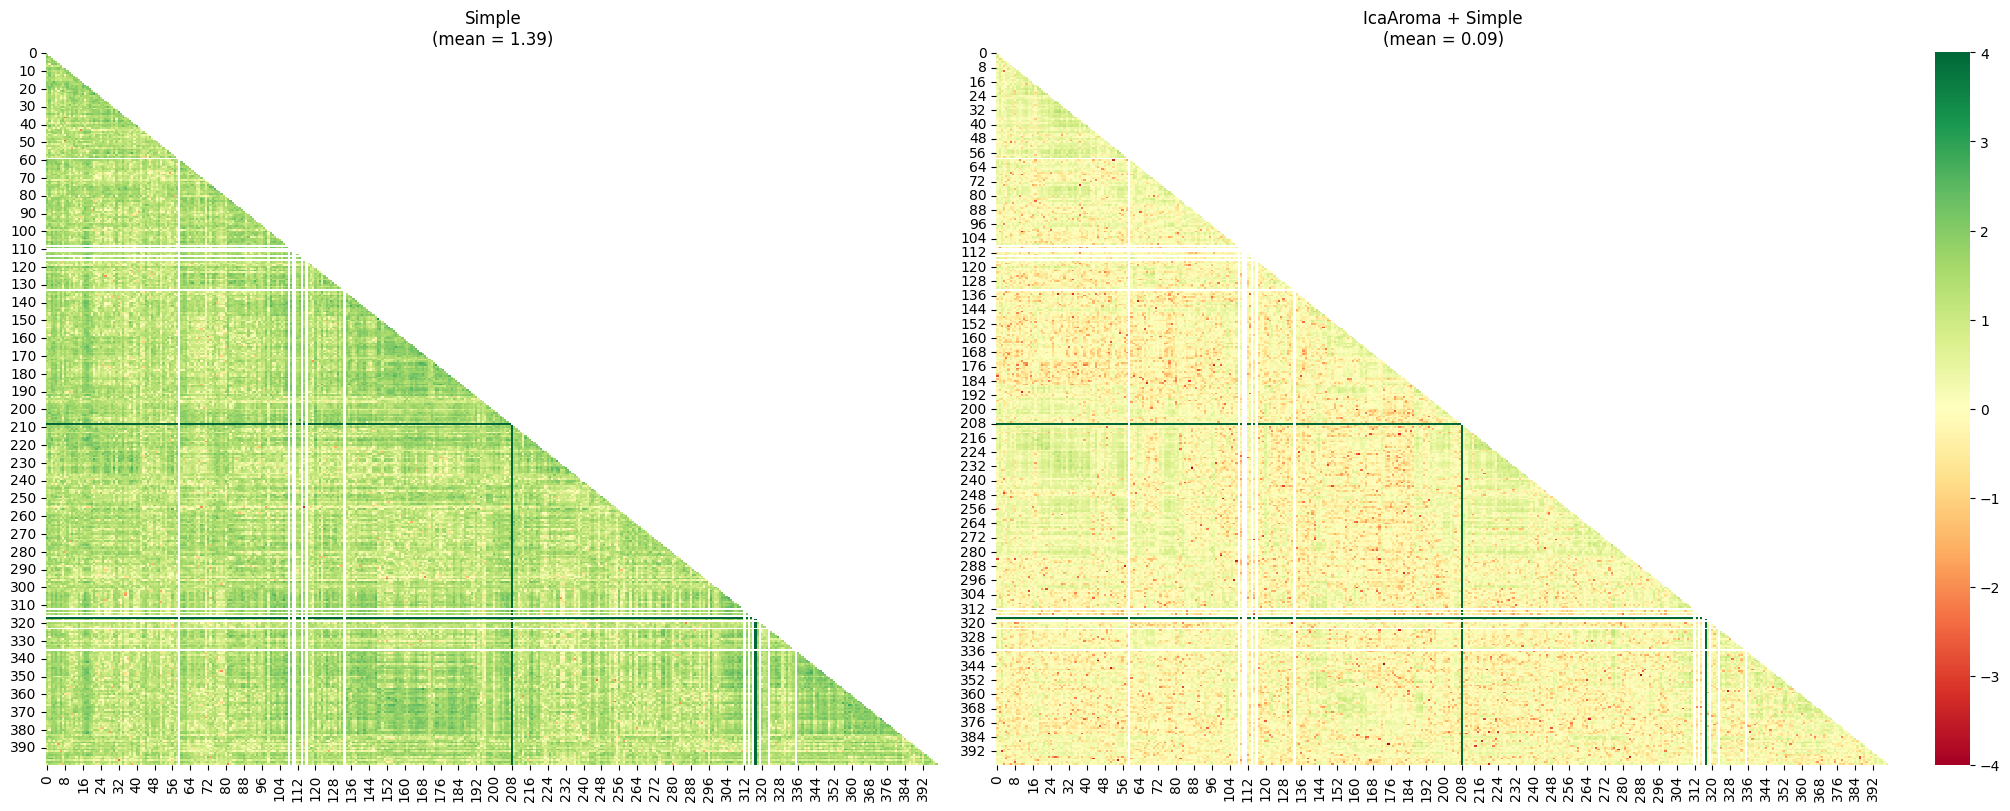

In [91]:

figure, axes_array = plt.subplots(
    ncols=2, sharex=True, figsize=(20, 8), constrained_layout=True
)

make_sigdigs_plot("Simple", axes_array[0], 3, subject_index, False)
make_sigdigs_plot("IcaAroma + Simple", axes_array[1], 9, subject_index, True)

In [70]:
# List of pipeline titles
pipeline_titles = [
    'FalseComb0', 'FalseComb1', 'FalseComb2', 'FalseComb3',
    'FalseComb4', 'FalseComb5', 'TrueComb0', 'TrueComb1',
    'TrueComb2', 'TrueComb3', 'TrueComb4', 'TrueComb5'
]

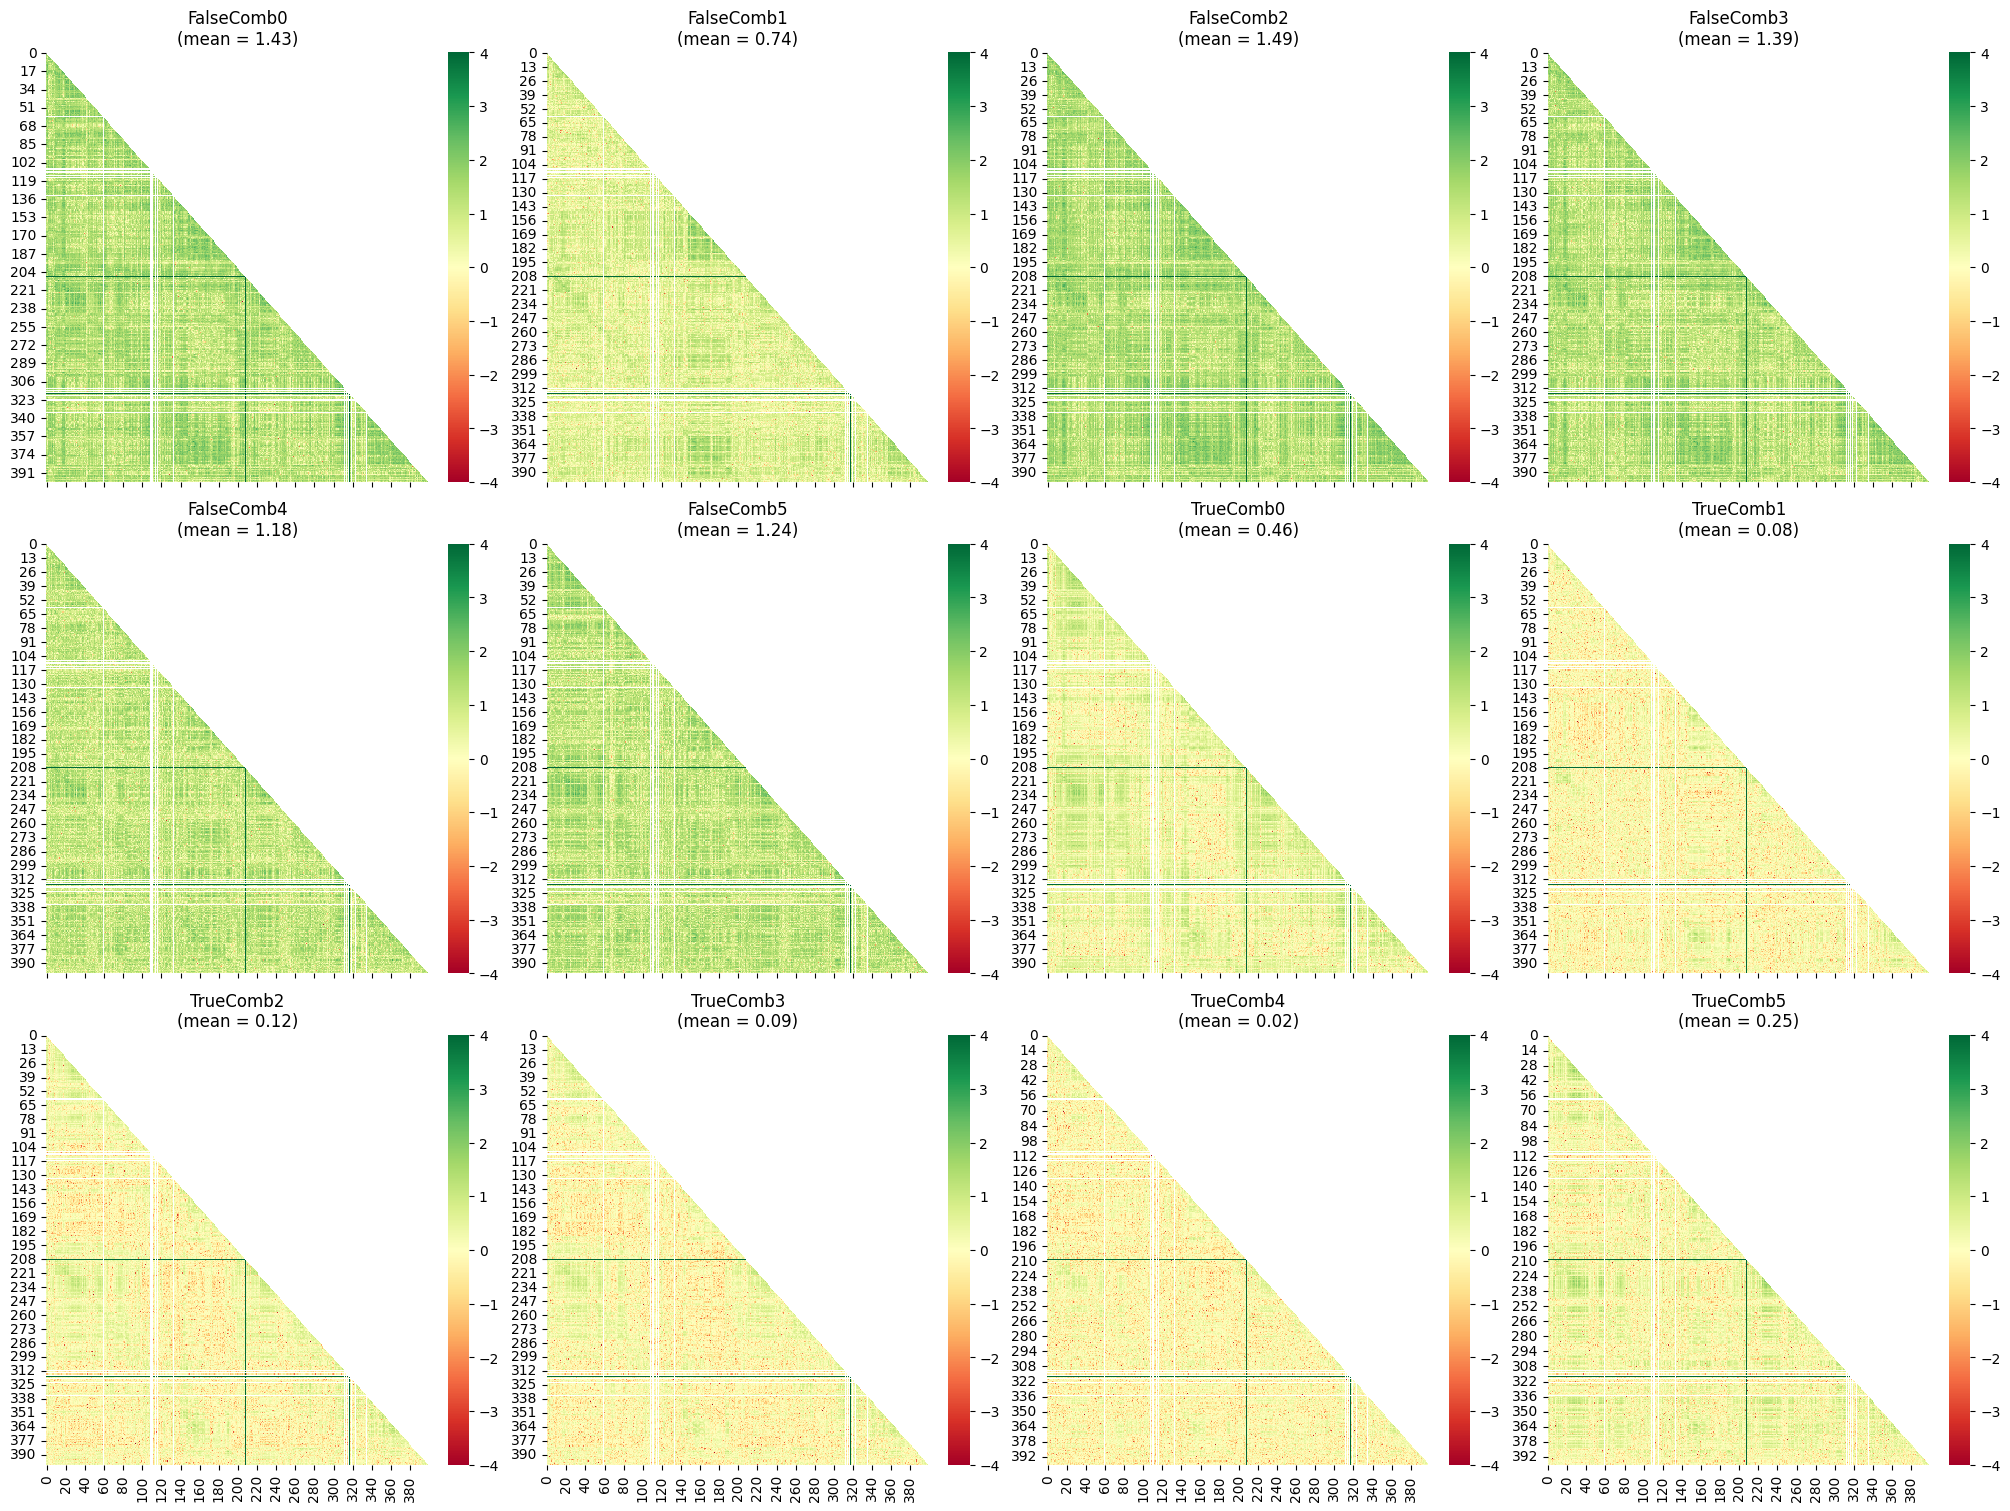

In [87]:
# Create subplots for 12 pipelines
fig, axes_array = plt.subplots(
    nrows=3, ncols=4, sharex=True, figsize=(20, 15), constrained_layout=True
)

axes_array = axes_array.flatten() #

for i, (title, ax) in enumerate(zip(pipeline_titles, axes_array)):
    make_sigdigs_plot(title, ax, i, subject_index, True)

plt.show()

In [23]:
import scipy.stats

scipy.stats.ttest_rel(make_sigdigs_vector(1), make_sigdigs_vector(6), nan_policy="omit")

TtestResult(statistic=nan, pvalue=nan, df=nan)

In [22]:
import numpy.ma as ma

a, b = make_sigdigs_vector(1, 1), make_sigdigs_vector(6, 1)
ma.corrcoef(ma.masked_invalid(a), ma.masked_invalid(b))

masked_array(
  data=[[--, --],
        [--, --]],
  mask=[[ True,  True],
        [ True,  True]],
  fill_value=1e+20,
  dtype=float64)

(-2.0, 3.0)

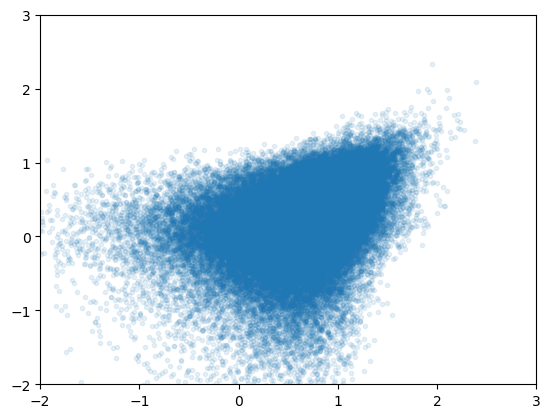

In [181]:
plt.plot(make_sigdigs_vector(1), make_sigdigs_vector(6), ".", alpha=0.1)
plt.ylim(-2, 3)
plt.xlim(-2, 3)

In [169]:
np.nanmean(make_signdigs_array(1)), np.nanmean(make_signdigs_array(6))

(np.float64(0.7506430485664511), np.float64(0.3567614650303614))

In [13]:
# ds.to_netcdf(
#     "/lea/downloads/saved_on_disk.h5",
#     engine="h5netcdf",
#     encoding=dict(
#         functional_connectivity=dict(
#             compression="gzip", compression_opts=9, shuffle=True
#         )
#     ),
# )

In [28]:
mean = ds.functional_connectivity.mean(axis=(1))

In [29]:
ds.functional_connectivity[:, :, 0, 0].shape, mean[:, 0, 0, np.newaxis].shape

IndexError: too many indices

In [30]:


xr.corr(ds.functional_connectivity[:, :, 0, 0], mean[:, 0, 0], dim="cell")



<xarray.DataArray 'functional_connectivity' (iteration: 100)> Size: 800B
array([0.99984655, 0.99987761, 0.9992189 , 0.99955602, 0.99953035,
       0.99975706, 0.99909229, 0.99884525, 0.99981434, 0.99983853,
       0.99973357, 0.99985505, 0.99984802, 0.99984108, 0.99933392,
       0.99927232, 0.99988343, 0.99985986, 0.99969839, 0.99932996,
       0.99986772, 0.99949373, 0.99905983, 0.99943598, 0.99983092,
       0.99989437, 0.99962966, 0.99922913, 0.99946755, 0.99942358,
       0.99954067, 0.99927387, 0.99987285, 0.99979719, 0.9997493 ,
       0.99953942, 0.99983862, 0.99956462, 0.9993505 , 0.99959246,
       0.99993789, 0.99957946, 0.99986228, 0.99949502, 0.99973796,
       0.99972802, 0.99945272, 0.99959412, 0.99943525, 0.99974502,
       0.99943828, 0.99983697, 0.99986677, 0.9992939 , 0.99988162,
       0.99938832, 0.99945572, 0.99970443, 0.99976876, 0.99949604,
       0.99974152, 0.99862384, 0.99985736, 0.99983304, 0.99949165,
       0.99879454, 0.99956608, 0.9998794 , 0.99929494, 0.99948468,
       0.99992345, 0.99981492, 0.99987666, 0.99961309, 0.99915973,
       0.99989199, 0.99910403, 0.99984492, 0.99977805, 0.99964911,
       0.99977046, 0.99954059, 0.99951531, 0.99941309, 0.99945625,
       0.99979064, 0.99962241, 0.99877417, 0.99956219, 0.99912679,
       0.99977252, 0.9994423 , 0.99989983, 0.99936202, 0.9994525 ,
       0.99976269, 0.99931247, 0.9996405 , 0.99986367, 0.99988461])
Coordinates:
  * iteration  (iteration) int64 800B 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
    pipeline   <U10 40B 'FalseComb0'
    subject    <U9 36B 'sub-01'

In [ ]:
np.corrcoef(ds.functional_connectivity[:, :, 0, 0]).shape

### Seed connectivity

In [14]:
seed = np.load('data/sub-9040_seed.npz')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)
/var/folders/r9/skhy477x7kjfm4m8y6v5jhgw0000gn/T/ipykernel_63105/2210946125.py:10: RuntimeWarning: Mean of empty slice
  gc = sns.heatmap(np.nanmean(sigdigs, axis=0)[:, ::-1].T, ax=axes[0], cmap=cmap, vmin=-4, vmax=15, cbar=False)
/var/folders/r9/skhy477x7kjfm4m8y6v5jhgw0000gn/T/ipykernel_63105/2210946125.py:12: RuntimeWarning: All-NaN slice encountered
  gc = sns.heatmap(np.nanmax(sigdigs, axis=0)[:, ::-1].T, ax=axes[1], cmap=cmap, vmin=-4, vmax=15, cbar=False)
/var/folders/r9/skhy477x7kjfm4m8y6v5jhgw0000gn/T/ipykernel_63105/2210946125.py:14: RuntimeWarning: All-NaN slice encountered
  gc = sns.heatmap(np.nanmin(sigdigs, axis=0)[:, ::-1].T, ax=axes[2], cmap=cmap, vmin=-4, vmax=15, cbar=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/signific

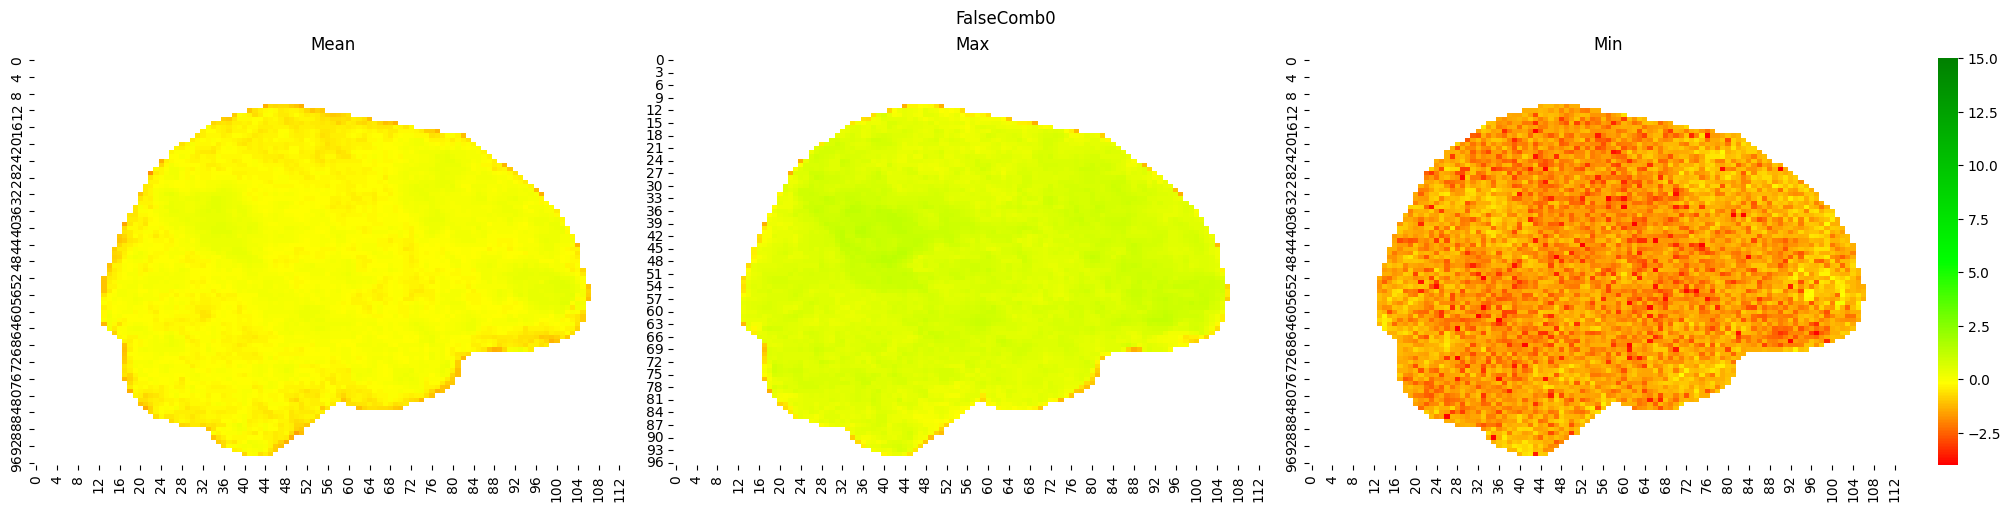

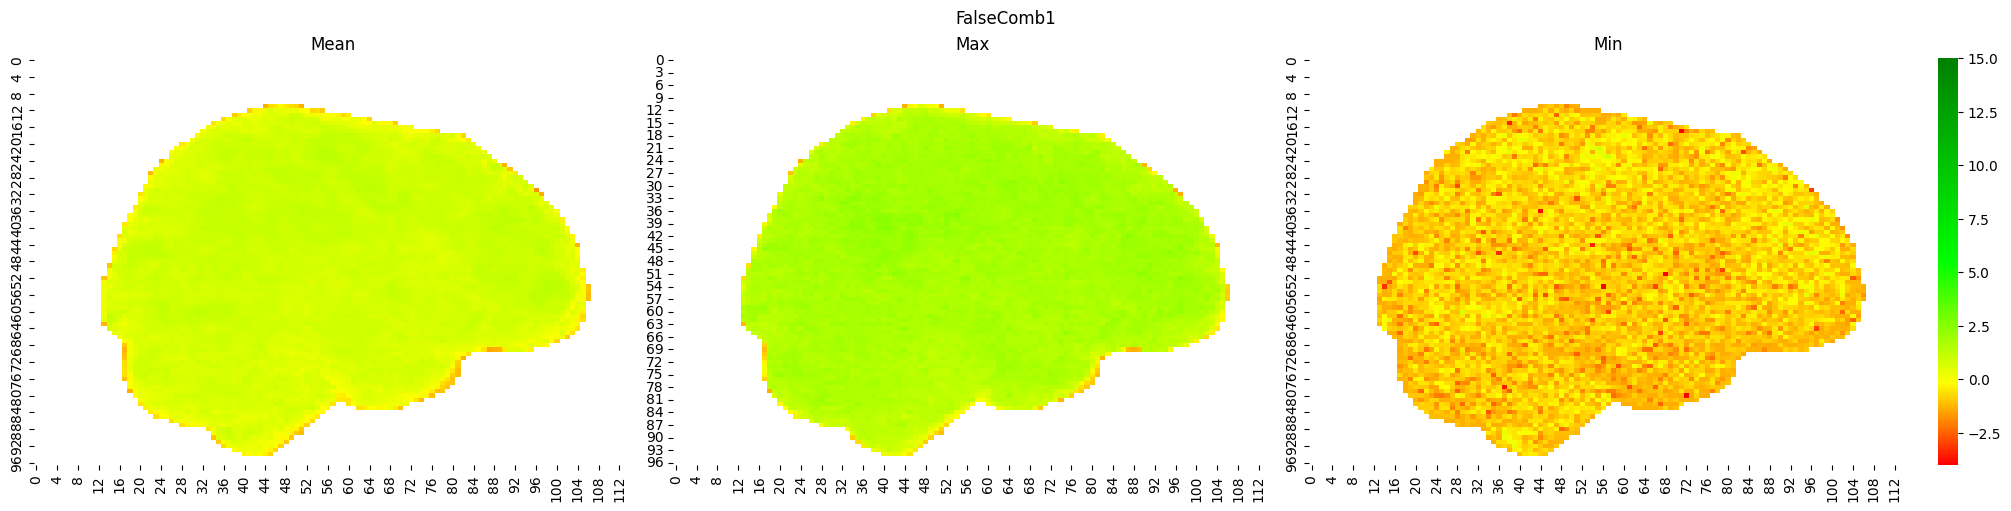

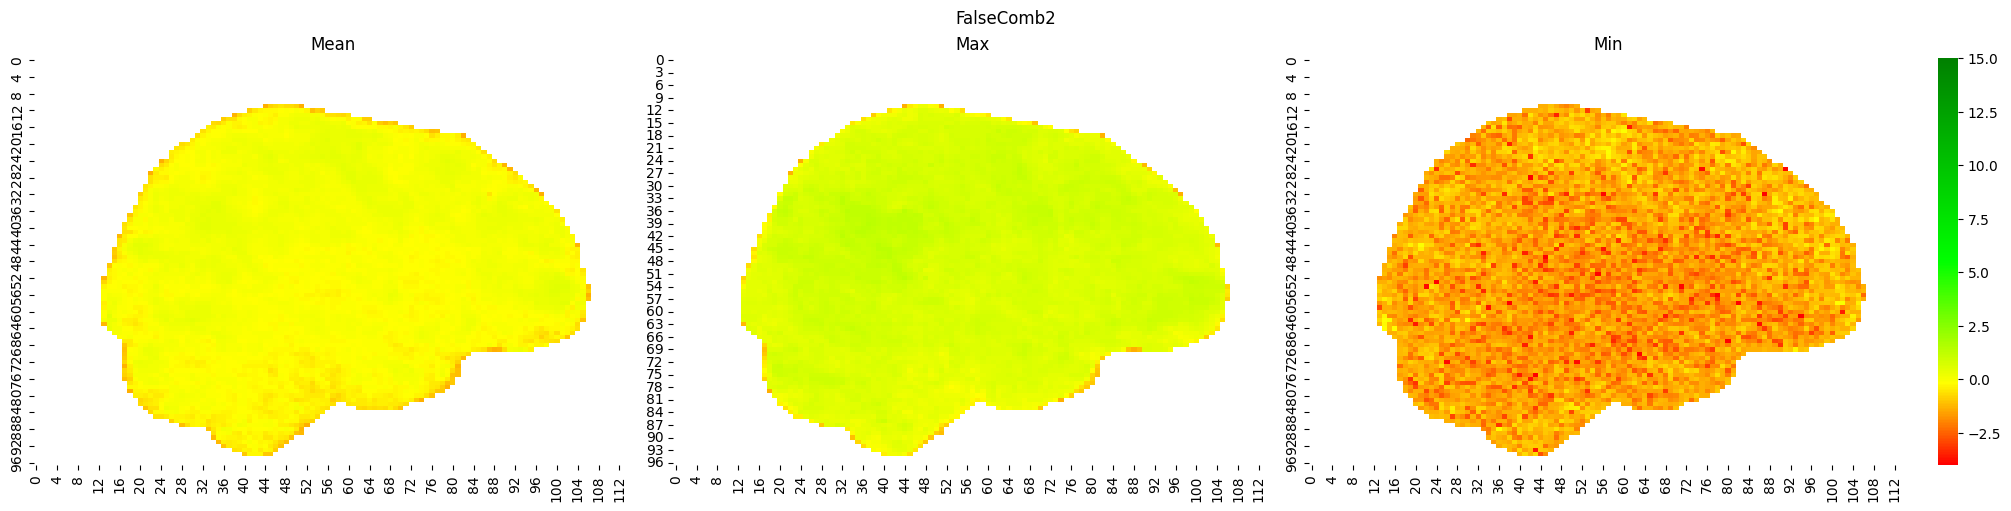

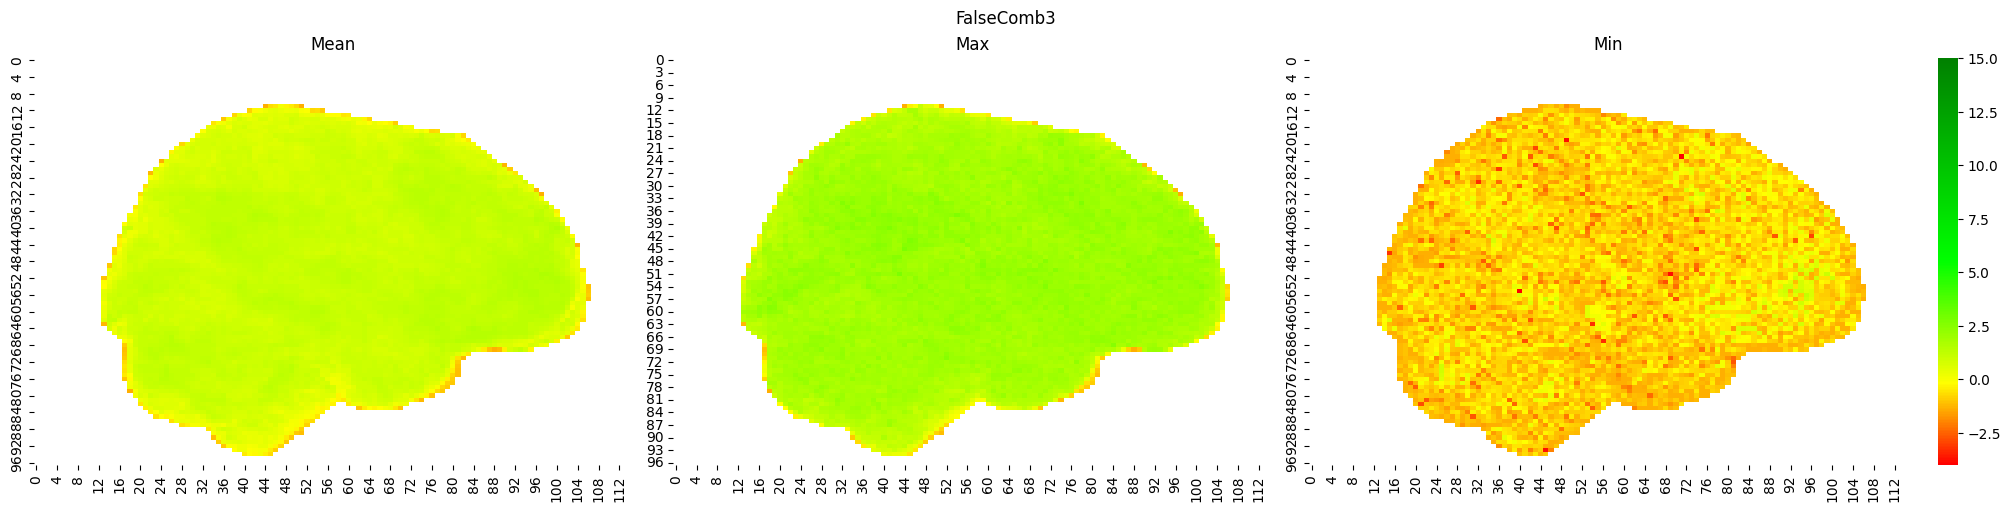

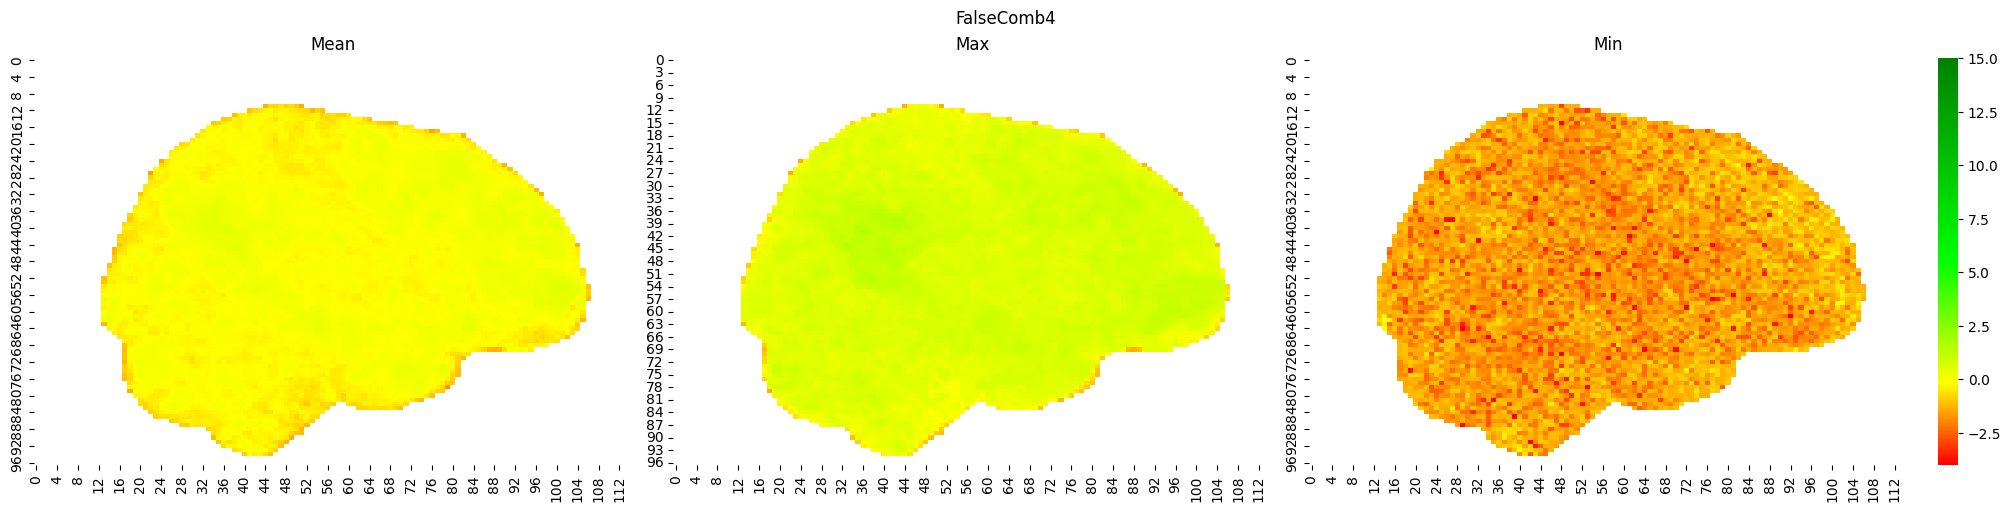

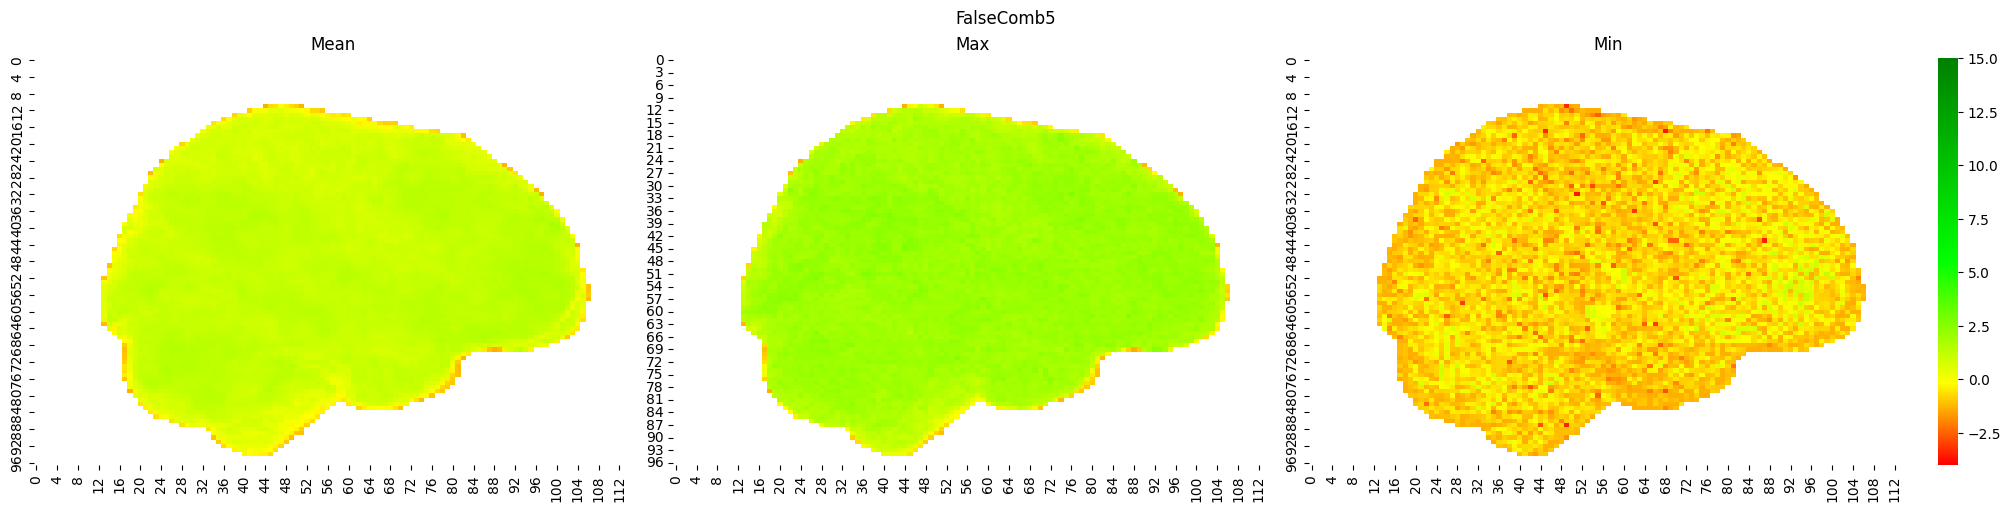

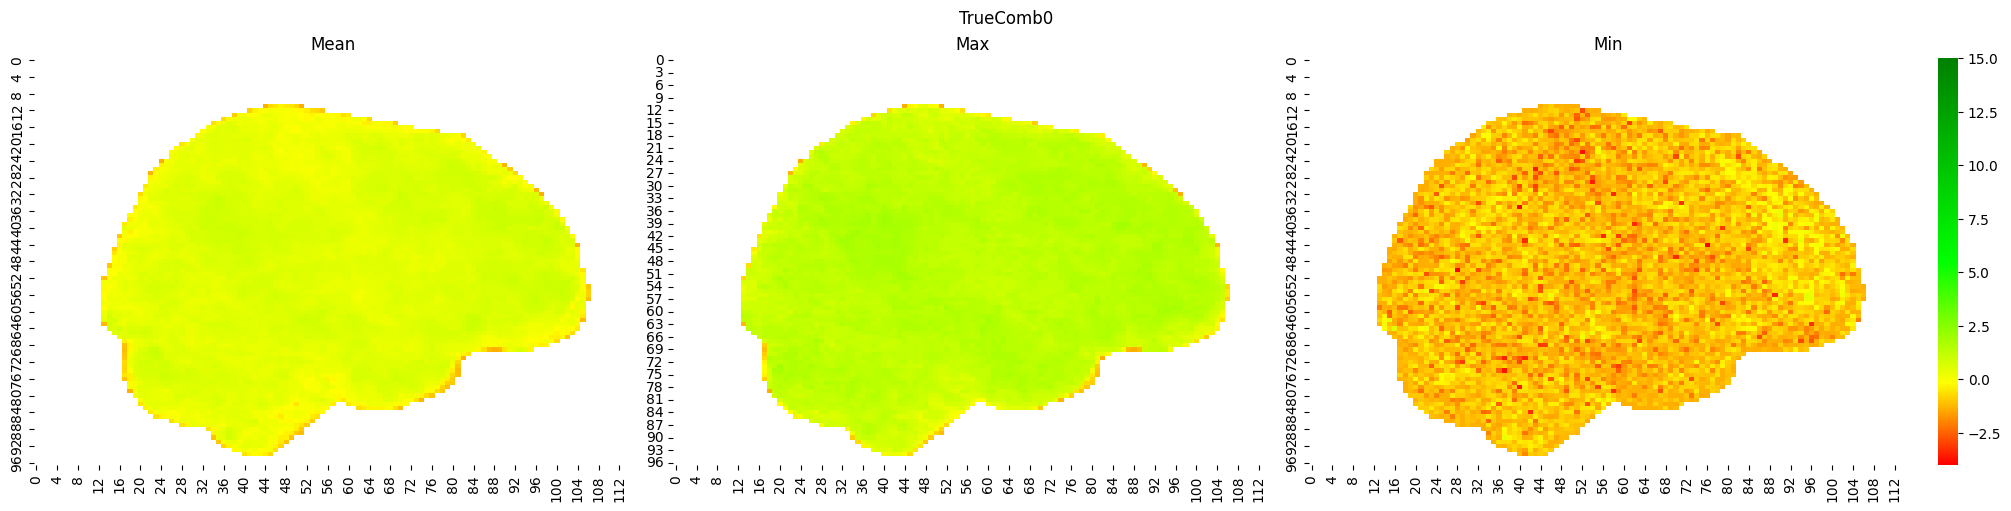

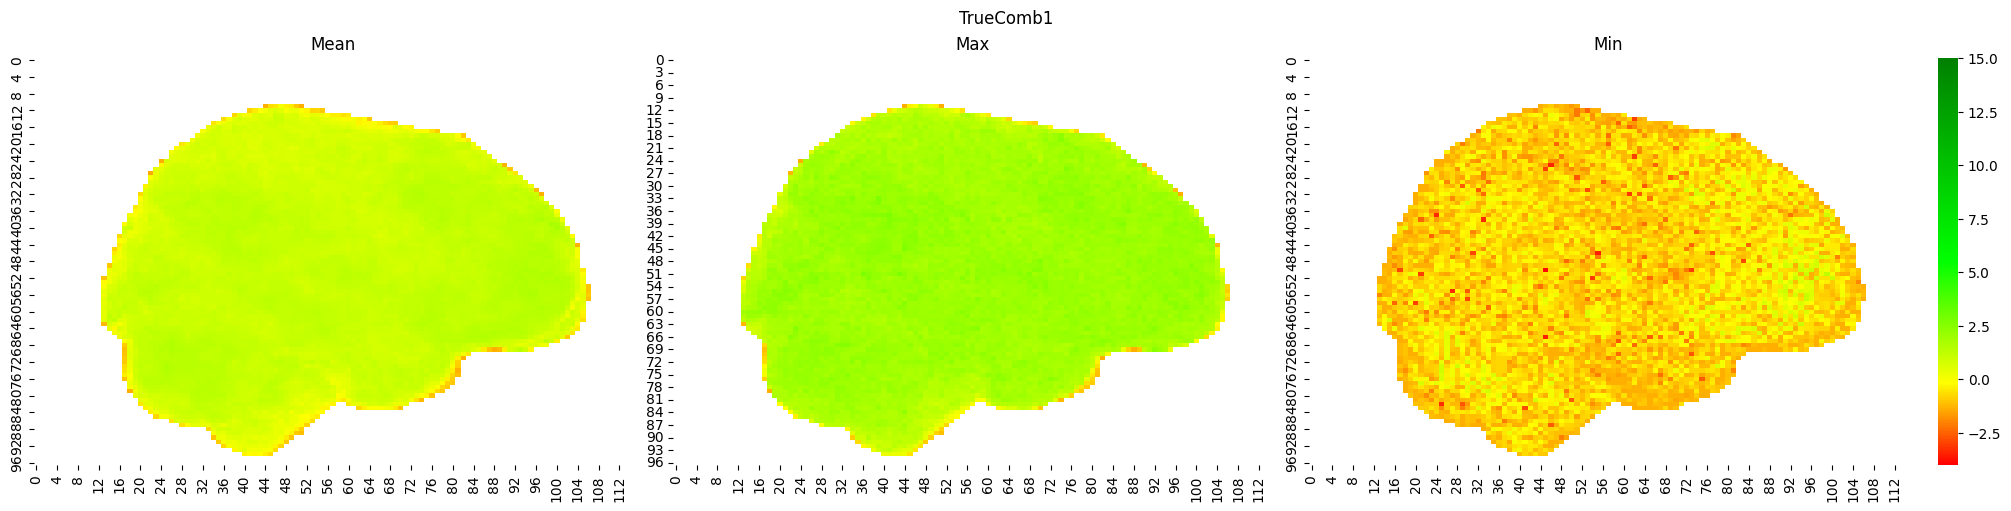

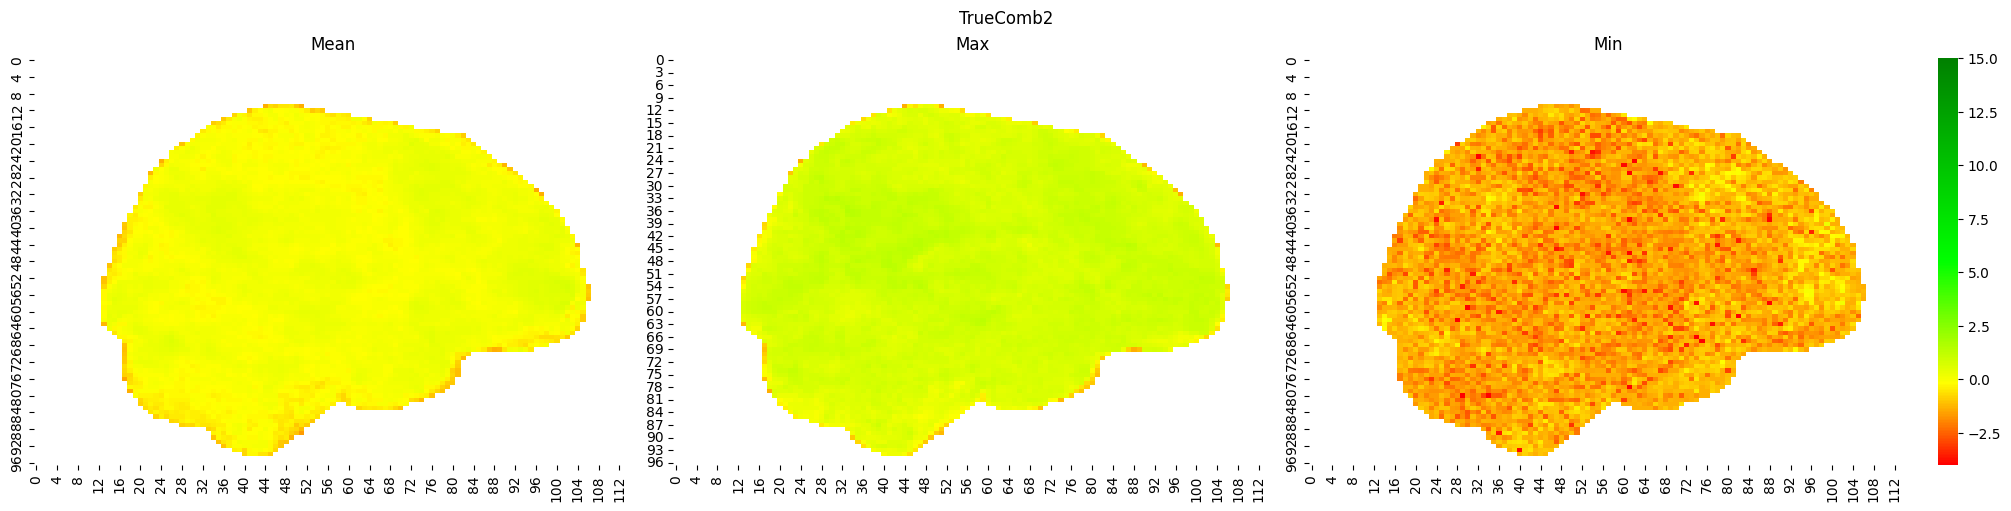

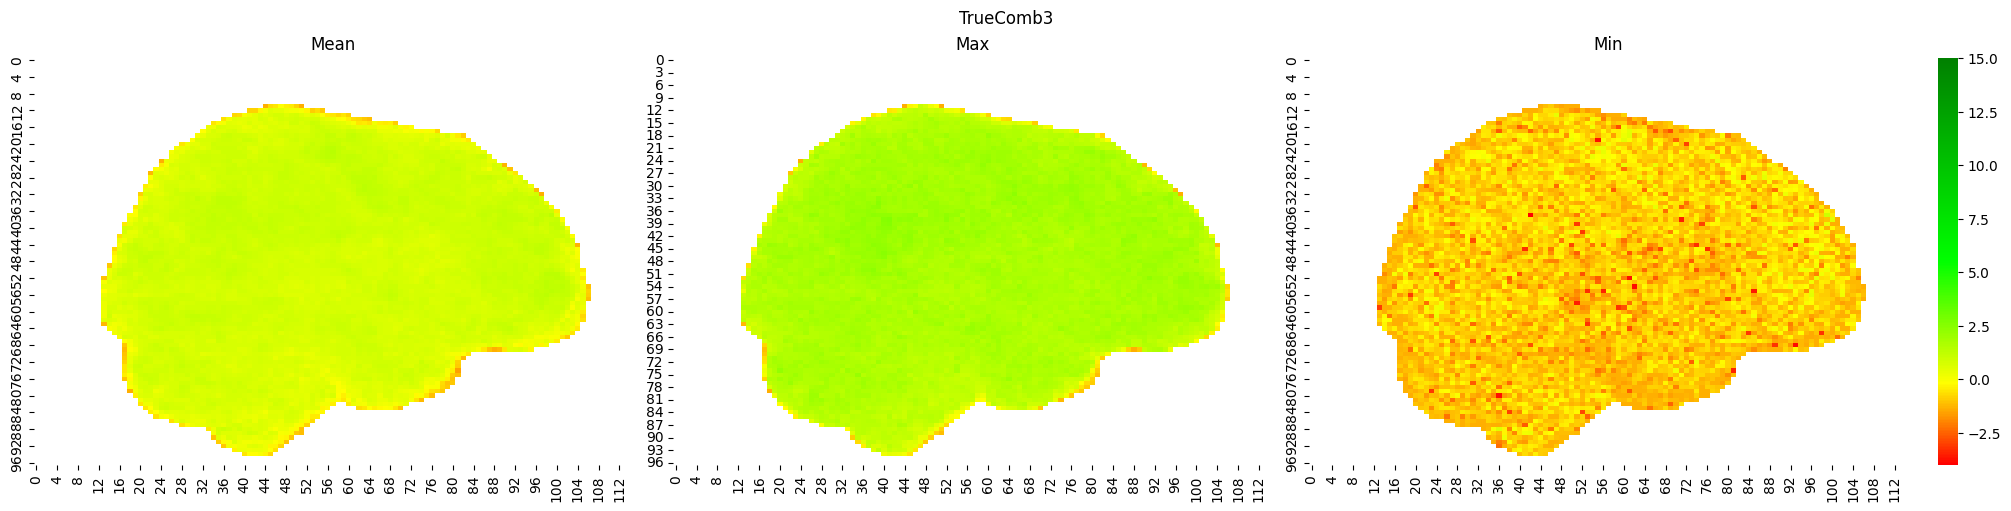

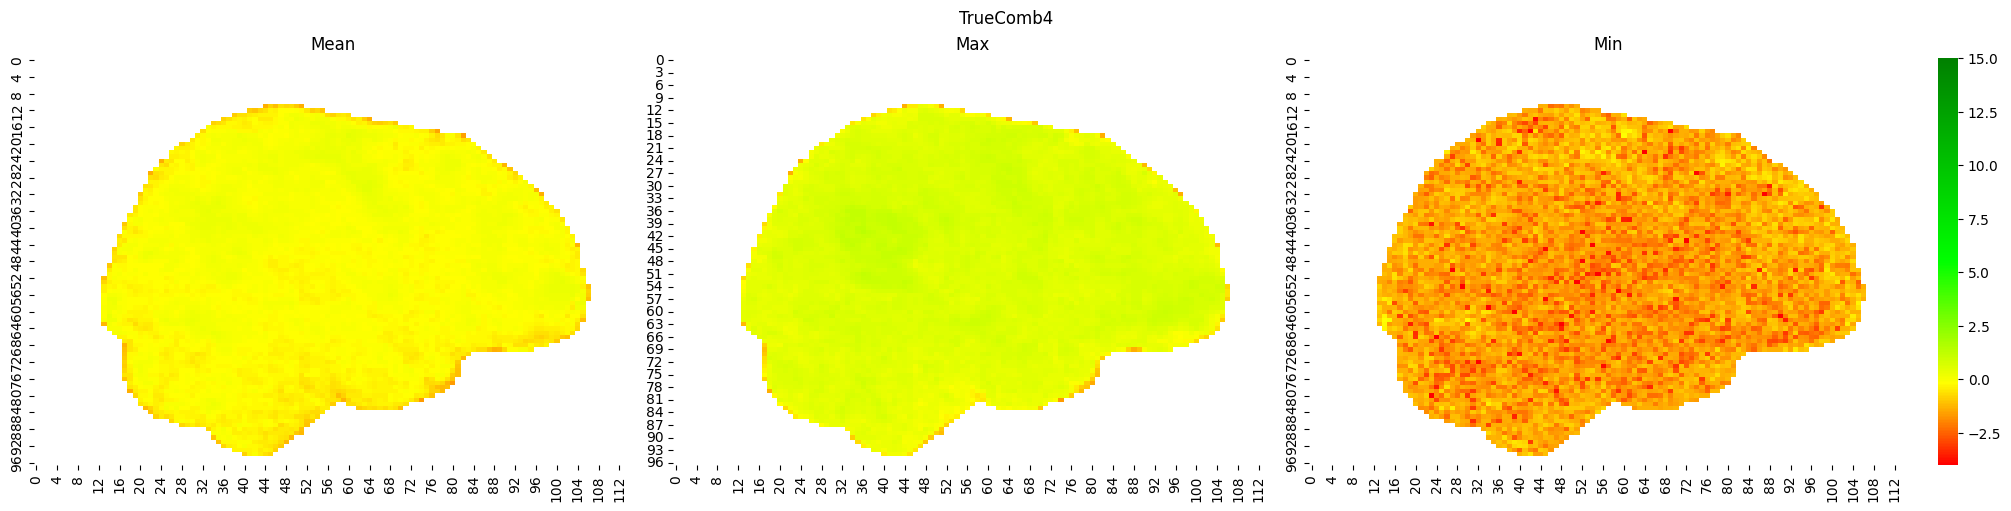

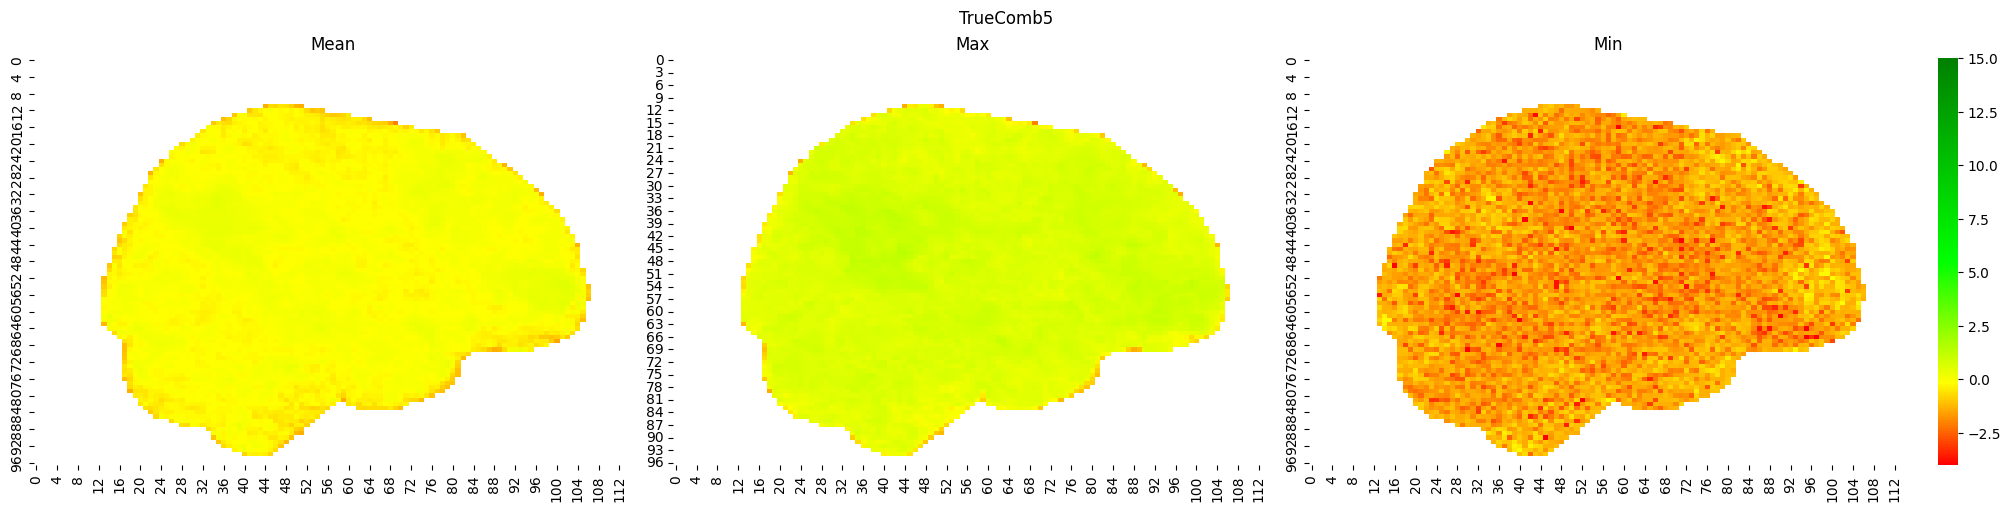

In [15]:
colors = ['Red', 'yellow', 'lime', 'green']
values = np.array([0, 0.2, 0.5, 1])
cmap = LinearSegmentedColormap.from_list("gangchen", list(zip(values, colors)))

for num,  pre_process in list(enumerate(pipelines)):
    sigdigs = sd.significant_digits(seed['arr_0'][num], reference=seed['arr_0'][num].mean(axis=0), basis=10)
    sigdigs[sigdigs >= 15] = np.nan
    fig, axes = plt.subplots(ncols=3, sharex=True, figsize=(20,5), constrained_layout=True)

    gc = sns.heatmap(np.nanmean(sigdigs, axis=0)[:, ::-1].T, ax=axes[0], cmap=cmap, vmin=-4, vmax=15, cbar=False)
    gc.set_title('Mean')
    gc = sns.heatmap(np.nanmax(sigdigs, axis=0)[:, ::-1].T, ax=axes[1], cmap=cmap, vmin=-4, vmax=15, cbar=False)
    gc.set_title('Max')
    gc = sns.heatmap(np.nanmin(sigdigs, axis=0)[:, ::-1].T, ax=axes[2], cmap=cmap, vmin=-4, vmax=15, cbar=True)
    gc.set_title('Min')
    plt.suptitle(pre_process)
    # break


/var/folders/r9/skhy477x7kjfm4m8y6v5jhgw0000gn/T/ipykernel_63105/3771921850.py:3: RuntimeWarning: Mean of empty slice
  gc = sns.heatmap(np.nanmean(sigdigs, axis=0)[:, ::-1].T, ax=axes[0], cmap=cmap, vmin=-4, vmax=15, cbar=False)
/var/folders/r9/skhy477x7kjfm4m8y6v5jhgw0000gn/T/ipykernel_63105/3771921850.py:5: RuntimeWarning: All-NaN slice encountered
  gc = sns.heatmap(np.nanmax(sigdigs, axis=0)[:, ::-1].T, ax=axes[1], cmap=cmap, vmin=-4, vmax=15, cbar=False)
/var/folders/r9/skhy477x7kjfm4m8y6v5jhgw0000gn/T/ipykernel_63105/3771921850.py:7: RuntimeWarning: All-NaN slice encountered
  gc = sns.heatmap(np.nanmin(sigdigs, axis=0)[:, ::-1].T, ax=axes[2], cmap=cmap, vmin=-4, vmax=15, cbar=True)


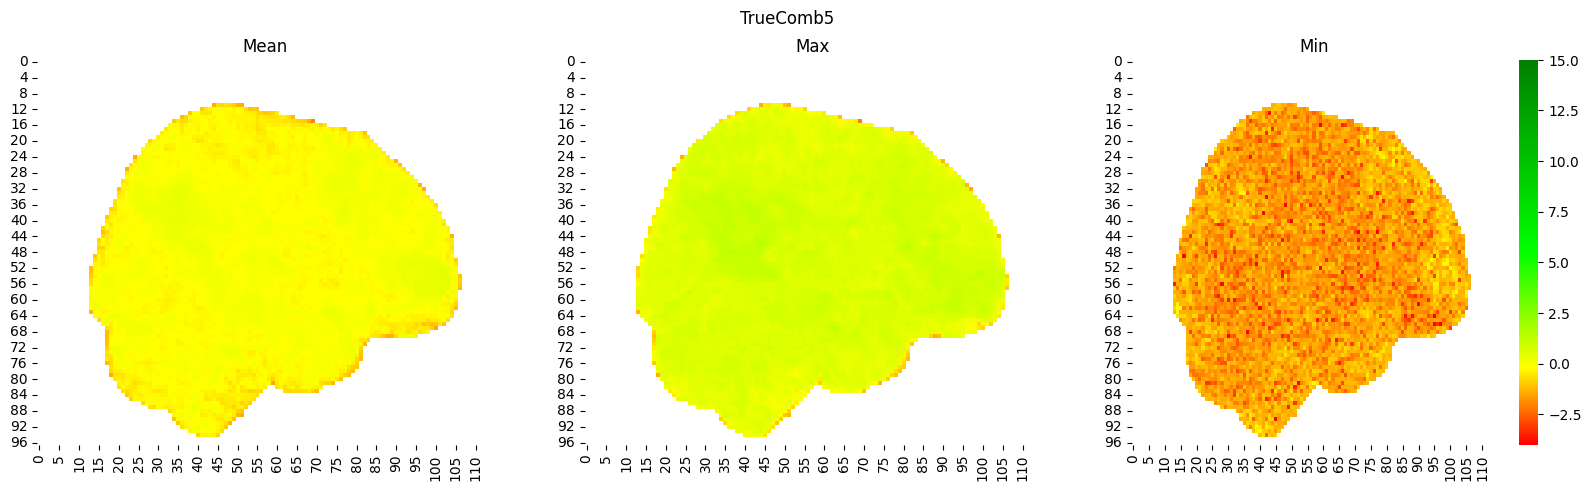

In [16]:
fig, axes = plt.subplots(ncols=3, sharex=True, figsize=(20,5), )

gc = sns.heatmap(np.nanmean(sigdigs, axis=0)[:, ::-1].T, ax=axes[0], cmap=cmap, vmin=-4, vmax=15, cbar=False)
gc.set_title('Mean')
gc = sns.heatmap(np.nanmax(sigdigs, axis=0)[:, ::-1].T, ax=axes[1], cmap=cmap, vmin=-4, vmax=15, cbar=False)
gc.set_title('Max')
gc = sns.heatmap(np.nanmin(sigdigs, axis=0)[:, ::-1].T, ax=axes[2], cmap=cmap, vmin=-4, vmax=15, cbar=True)
gc.set_title('Min')
plt.suptitle(pre_process);

### Split paired distribution test

#### Idea

For each subject and pipeline we have ~100 iterations. In the following block we create a test that compares the distribution of the cell values for 70 of those iterations versus the resting 30. The test compares between these distributions with an independent t-test. The test is done for each cell per pipeline and subject, so it takes a bit of time. 

At the end, we plot the results of the tests. We want to plot the p-values in the place of the cells, where non-significant cells are transparent (i.e. masked) and significant cells (starting at 95% confidence) are plotted with a gradient, with stronger colors for more significant. 

#### Previous approaches


Both the Mann-Whitney and the Kolmogorov-Smirnov tests are nonparametric tests to compare two unpaired groups of data. Both compute P values that test the null hypothesis that the two groups have the same distribution. But they work very differently:

•The **Mann-Whitney test** first ranks all the values from low to high, and then computes a P value that depends on the discrepancy between the mean ranks of the two groups.

•The Kolmogorov-Smirnov test compares the cumulative distribution of the two data sets, and computes a P value that depends on the largest discrepancy between distributions.

**1. Interpreting the P value of KS test**. The P value is the answer to this question:

`"If the two samples were randomly sampled from identical populations, what is the probability that the two cumulative frequency distributions would be as far apart as observed? More precisely, what is the chance that the value of the Komogorov-Smirnov D statistic would be as large or larger than observed?"`
    
    If the P value is small, conclude that the two groups were sampled from populations with different distributions**. The populations may differ in median, variability or the shape of the distribution.


**2. Interpreting the P value of MWU test**. The P value is the answer to this question:

`"If the groups are sampled from populations with identical distributions, what is the chance that random sampling would result in the mean ranks being as far apart (or more so) as observed in this experiment?"`
    
    If the P value is small, you can reject the null hypothesis that the difference is due to random sampling, and conclude instead that the populations are distinct..


Reference: https://www.graphpad.com/guides/prism/latest/statistics/interpreting_results_kolmogorov-smirnov_test.htm





In [8]:
iterations = ds.iteration.values
np.random.seed(0)  # For reproducibility
np.random.shuffle(iterations)
group1 = iterations[:70]
group2 = iterations[70:]
group1, group2

(array([26, 86,  2, 55, 75, 93, 16, 73, 54, 95, 53, 92, 78, 13,  7, 30, 22,
        24, 33,  8, 43, 62,  3, 71, 45, 48,  6, 99, 82, 76, 60, 80, 90, 68,
        51, 27, 18, 56, 63, 74,  1, 61, 42, 41,  4, 15, 17, 40, 38,  5, 91,
        59,  0, 34, 28, 50, 11, 35, 23, 52, 10, 31, 66, 57, 79, 85, 32, 84,
        14, 89]),
 array([19, 29, 49, 97, 98, 69, 20, 94, 72, 77, 25, 37, 81, 46, 39, 65, 58,
        12, 88, 70, 87, 36, 21, 83,  9, 96, 67, 64, 47, 44]))

In [9]:
p_values = np.zeros(ds.functional_connectivity.shape[0])
p_values.shape

(79800,)

In [12]:
calculate_p_values(1,1)

array([0.15938801, 0.51723417, 0.44925898, ..., 0.30289699, 0.35721009,
       0.6630301 ], shape=(79800,))

In [13]:
def calculate_p_values(pipeline_index: int, subject_index: int):
    '''
    Define the split of the data correctly (!) Here we are comparing 70 iterations vs. 30
    Define first which of the stats methods we will be using.
    '''
    
    iterations = ds.iteration.values
    np.random.seed(0)  # For reproducibility
    np.random.shuffle(iterations)
    group1 = iterations[:70]
    group2 = iterations[70:]

    p_values = np.zeros(ds.functional_connectivity.shape[0]) # Create array of 0s to store p-values
    
    for i in range(ds.functional_connectivity.shape[0]): # for each cell in 79800
        data_group1 = ds.functional_connectivity[i, group1, pipeline_index, subject_index]
        data_group2 = ds.functional_connectivity[i, group2, pipeline_index, subject_index]
        #print("data shape 1 ",data_group1.shape)
        #print("data shape 2 ",data_group2.shape)
        _, p_value = scipy.stats.ks_2samp(data_group1, data_group2)  #KS test !
        #_, p_value = scipy.stats.mannwhitneyu(data_group1, data_group2) 
        # _, p_value = scipy.stats.ttest_ind(data_group1, data_group2, equal_var=True) 
            #non parametric version of Independent t_test ?  
        #_, p_value = ttest_rel(data_group1, data_group2) # Perform paired t-test. But this does not make sense 

        p_values[i] = p_value

    return p_values

def make_p_values_array(pipeline_index: int, subject_index: int):
    p_values = calculate_p_values(pipeline_index, subject_index)
    array = np.full(fill_value=np.nan, shape=(k, k))
    array[*np.tril_indices(k, -1)] = p_values
    return array 
    
def plot_p_values(title: str, ax, pipeline_index: int, subject_index: int):
    array = make_p_values_array(pipeline_index, subject_index)
    significance_level = 0.05
    significant_mask = array < significance_level
    mask = np.isnan(array) | ~significant_mask    # Create a mask for non-significant values
    
    sns.heatmap(array, mask=mask, cmap="viridis_r", cbar=True, ax=ax)

    # Calculate the percentage of significant cells
    total_cells = np.sum(~np.isnan(array))
    significant_cells = np.sum(significant_mask)
    percentage_significant = (significant_cells / total_cells) * 100
    
    ax.set_title(f"{title}\n(Significant percentage (Diff distributions) = {percentage_significant:.2f} % )")

def extract_significant_indices(p_values, threshold=0.01):
    significant_indices = np.where(p_values < threshold)[0]
   # significant_indices = np.where(np.isfinite(p_values) & (p_values < threshold))[0]
    if len(significant_indices) == 0:
        raise ValueError("No significant cells found")
    return significant_indices

def compare_2distributions(cell_index, pipeline_index, subject_index, p_value):
    iterations = ds.iteration.values
    group1 = iterations[:70]
    group2 = iterations[70:]

    data_group1 = ds.functional_connectivity[cell_index, group1, pipeline_index, subject_index]
    data_group2 = ds.functional_connectivity[cell_index, group2, pipeline_index, subject_index]
    print(data_group1)
    print(data_group2)

    
    plt.figure(figsize=(10, 6))
    sns.histplot(data_group1, bins=20, kde=True, stat="count", color='blue', label='Group 1 (70 iterations)')
    sns.histplot(data_group2, bins=20, kde=True, stat="count", color='orange', label='Group 2 (30 iterations)')
    plt.title(f'Distributions for Cell {cell_index} in pipeline {pipelines[pipeline_index]}, {subjects[subject_index]}, (p-value: {p_value:.4e})') 
    plt.legend()
    plt.show()

In [20]:
pipelines

['FalseComb0',
 'FalseComb1',
 'FalseComb2',
 'FalseComb3',
 'FalseComb4',
 'FalseComb5',
 'TrueComb0',
 'TrueComb1',
 'TrueComb2',
 'TrueComb3',
 'TrueComb4',
 'TrueComb5']

In [28]:
pipelines[6]

'TrueComb0'

In [29]:
# Plotting for one subject and one pipeline
pipeline_index = 8
subject_index = 1

p_values = calculate_p_values(pipeline_index, subject_index)
significant_cells_indices = extract_significant_indices(p_values, threshold=0.01)
print(f"Significant cells indices: {significant_cells_indices}")


Significant cells indices: [  759  2102  2162  2281  2301  2416  2428  2431  2433  2555  2610  2613
  2614  2619  2622  2624  2700  2712  2777  2809  2845  3073  3074  3076
  3350  3355  3367  3502  3504  3506  3510  3511  3516  3532  4799  4807
  4809  5123  5137  5167  5169  5226  7266  7289  7304  7311  7327  7335
  7360  7972  8133  8134  8190  8191  8195  8203  8274  8275  8281  8285
  8286  8290  8310  8314  8376  8457  8460  8466  8469  8477  8485  8491
  8516  8538  8588  8596  8850  8983 10968 11019 11325 11392 11397 11399
 11409 11417 11420 11422 11427 11445 11571 11721 11728 11729 11735 11829
 12085 12395 12781 12822 13113 13116 13130 13143 13156 13161 13356 13651
 13664 14100 14125 14268 14797 14803 15286 15297 15300 15303 15306 15308
 15317 15323 15325 15327 15461 15487 15637 15669 15678 15693 15967 16207
 16209 16234 16267 16562 16619 16687 16813 16908 16929 16936 16938 16964
 17180 17188 17440 17441 17483 17656 17896 18498 18851 19006 19446 19686
 20114 20175 20502 20568

In [18]:
len(significant_cells_indices)

1118

<xarray.DataArray 'functional_connectivity' (iteration: 70)> Size: 560B
array([ 0.30443263,  0.137284  ,  0.28868122,  0.30961695,  0.2545525 ,
        0.07396474,  0.35466201,  0.15193793,  0.37196447,  0.35433904,
        0.25869987,  0.37206066,  0.25559041,  0.38340106,  0.18497285,
       -0.0832825 ,  0.24752816,  0.20648109,  0.18201338,  0.07606931,
        0.28380245,  0.39527964,  0.43493514,  0.36771838, -0.0155464 ,
        0.36574588,  0.40065023,  0.18522354,  0.15286138,  0.40771925,
        0.08190486,  0.24590346,  0.18359308,  0.22321074,  0.35532578,
        0.15685452,  0.39094003,  0.2745238 , -0.01891702,  0.21844755,
        0.12225149,  0.28020346,  0.19851431,  0.34289122,  0.45184221,
        0.30027371,  0.38011535,  0.4052125 ,  0.37958293,  0.14252582,
        0.14310472,  0.1668684 ,  0.4085762 ,  0.28970731,  0.39501995,
        0.050464  ,  0.15283436,  0.36166967,  0.1168374 ,  0.00152618,
        0.08817091,  0.31114631,  0.28995331,  0.12599327,  0.29

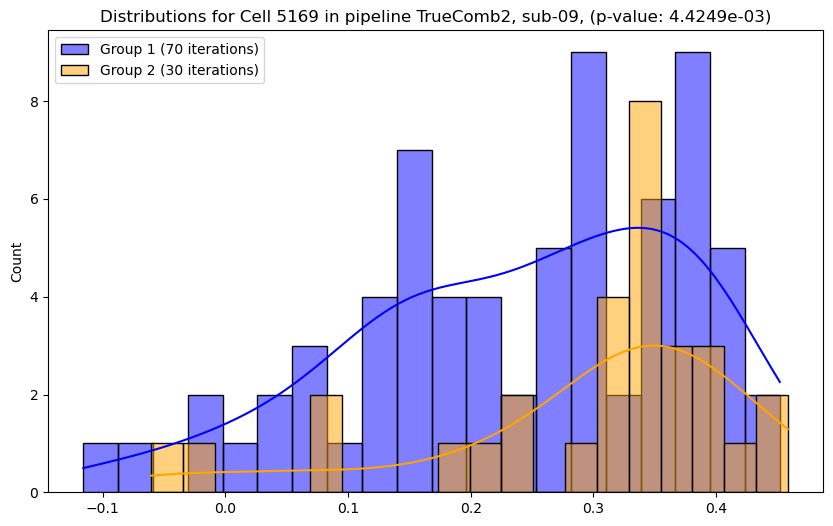

0.004424915662631635


In [35]:
select=40

cell_index = significant_cells_indices[select]  
p_value = p_values[cell_index]
compare_2distributions(cell_index, pipeline_index, subject_index, p_value)
print(p_value)

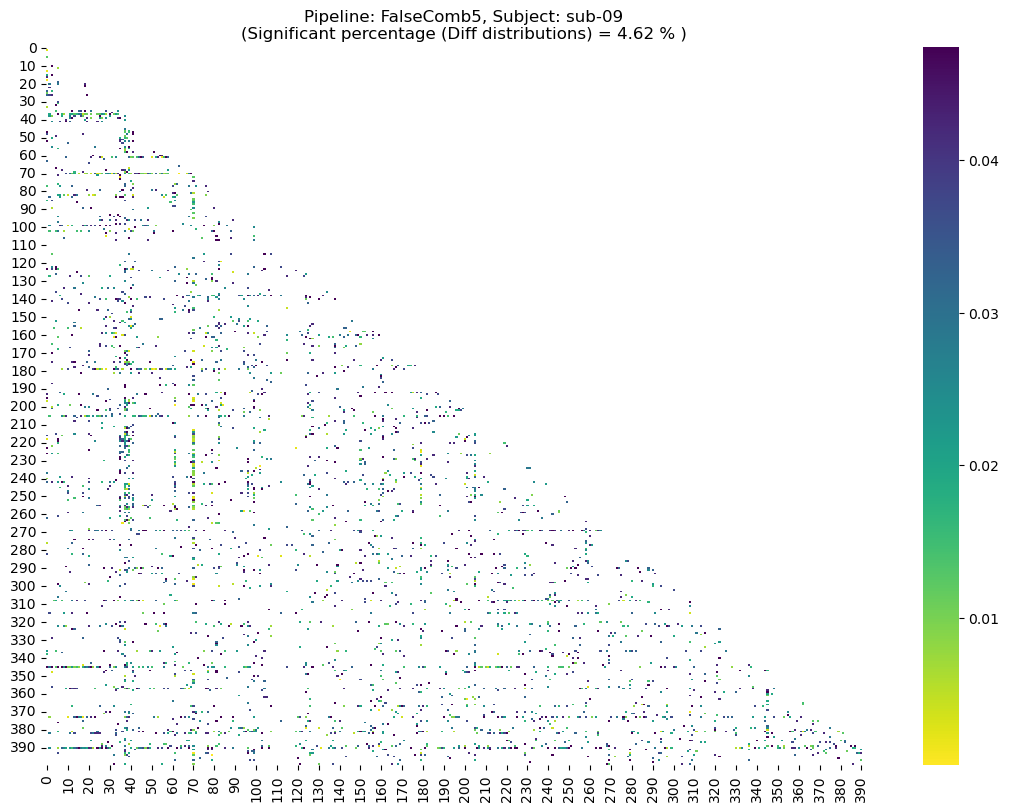

In [39]:
fig, ax = plt.subplots(figsize=(10, 8), constrained_layout=True)
plot_p_values(f"Pipeline: {pipelines[pipeline_index]}, Subject: {subjects[subject_index]}", ax, pipeline_index, subject_index)
plt.show()

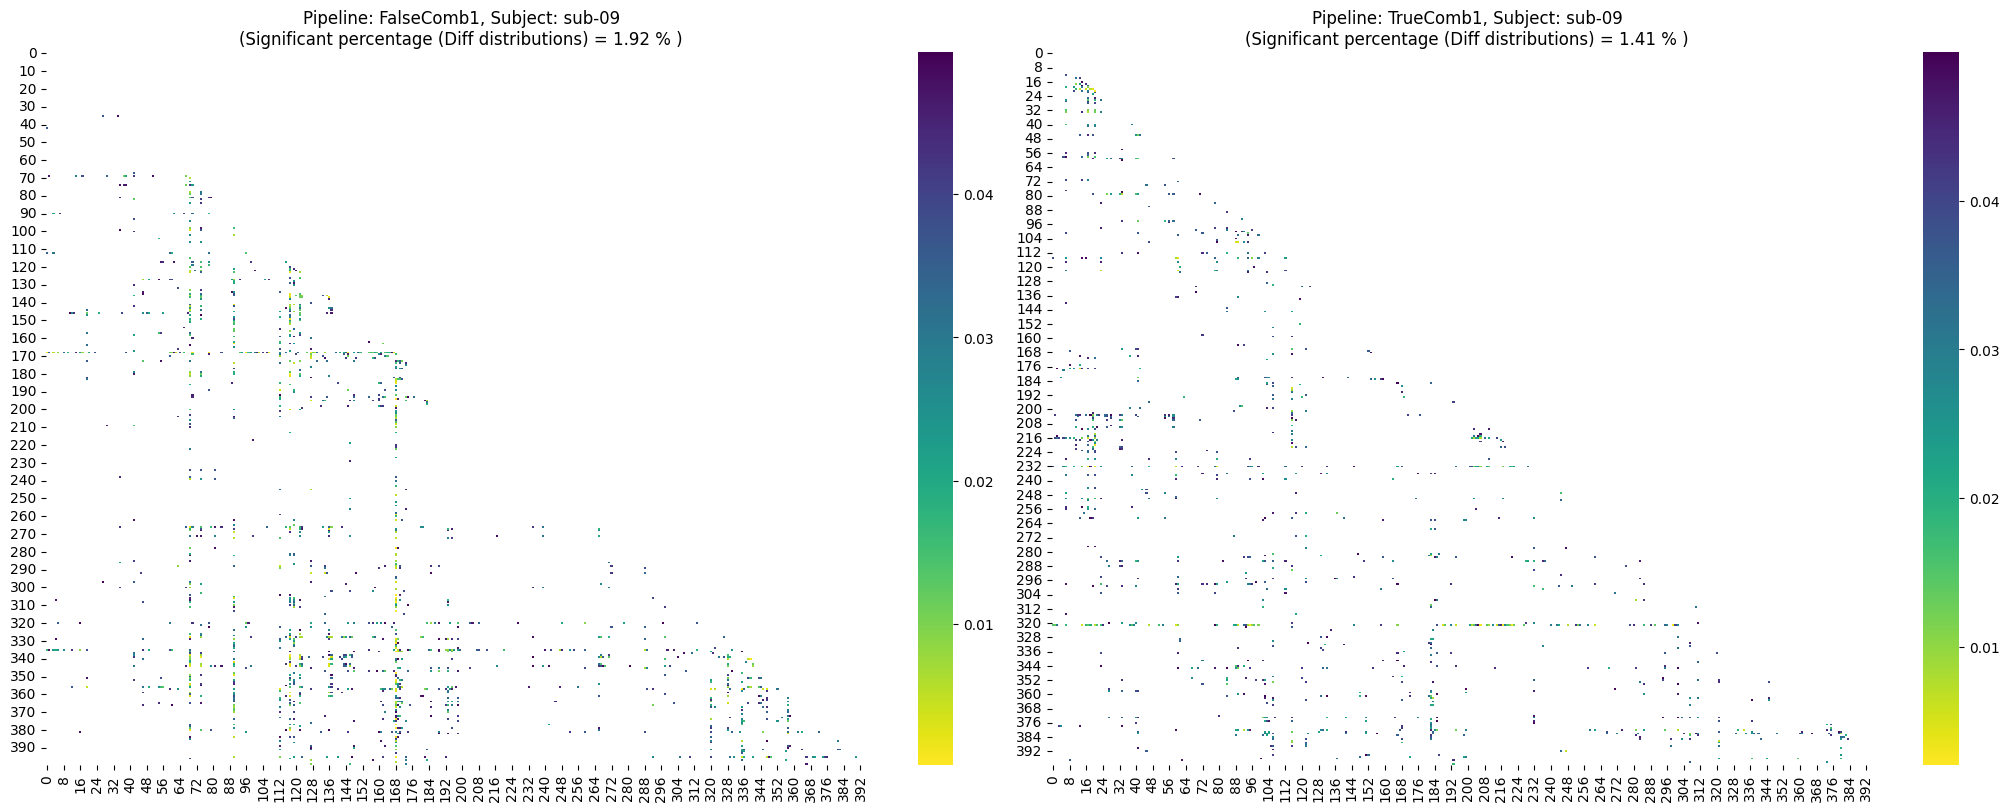

In [28]:
figure, axes_array = plt.subplots(ncols=2, sharex=True, figsize=(20, 8), constrained_layout=True)

plot_p_values(f"Pipeline: {pipelines[1]}, Subject: {subjects[subject_index]}", axes_array[0], 1, subject_index)
plot_p_values(f"Pipeline: {pipelines[7]}, Subject: {subjects[subject_index]}", axes_array[1], 7, subject_index)

In [56]:
subjects = ds.subject.values
pipelines = ds.pipeline.values
subjects[:2]

array(['sub-01', 'sub-09'], dtype='<U9')

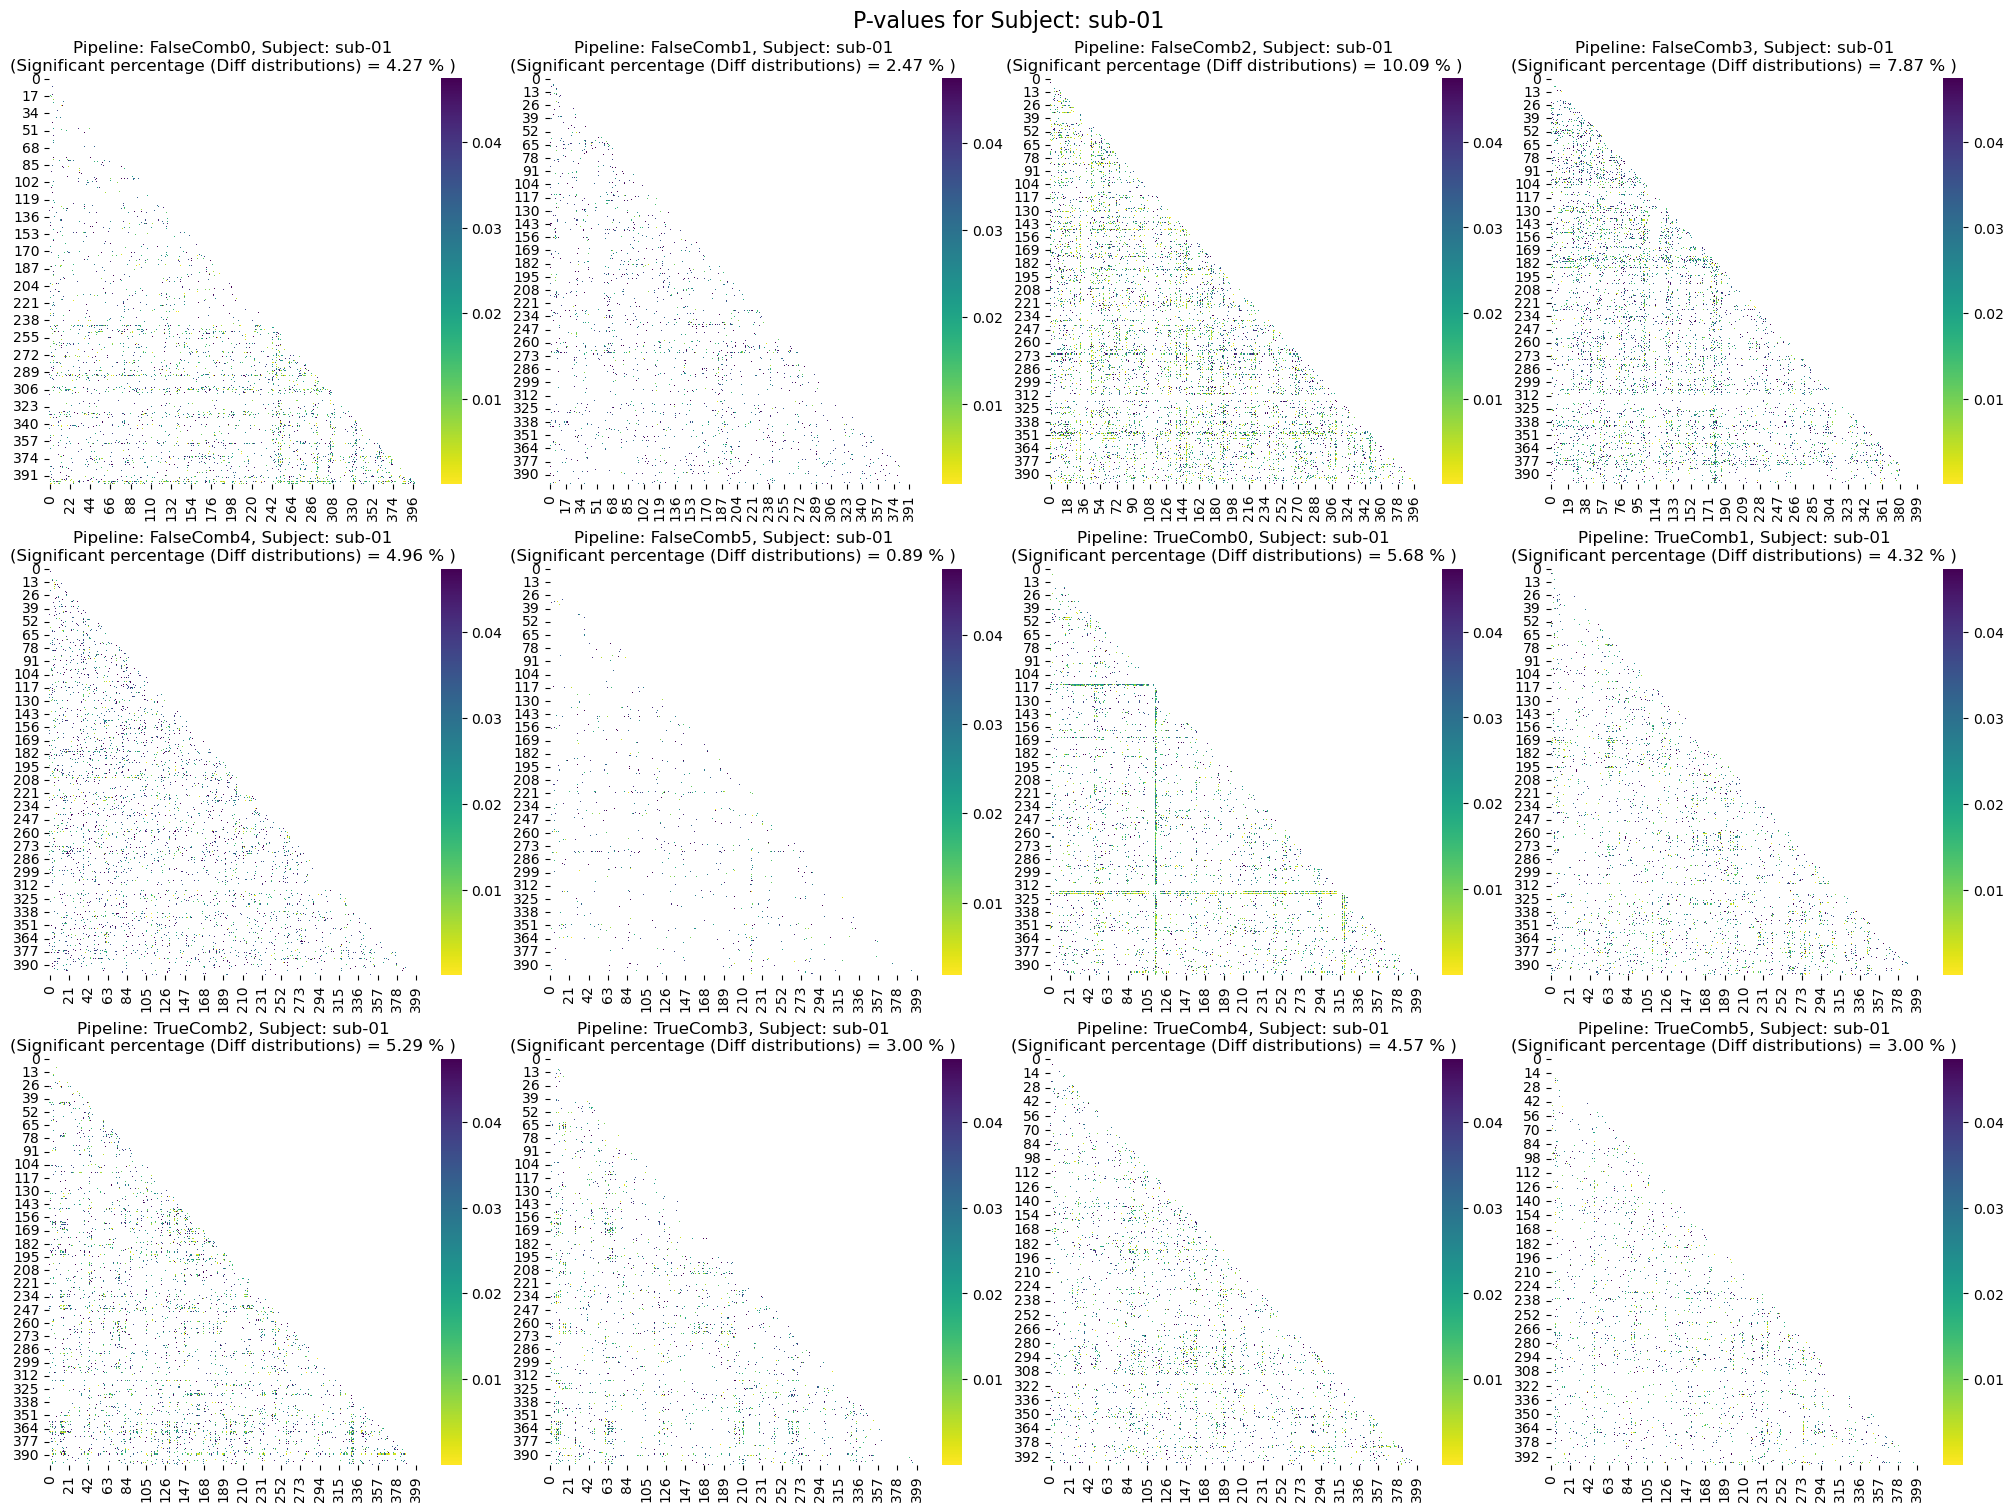

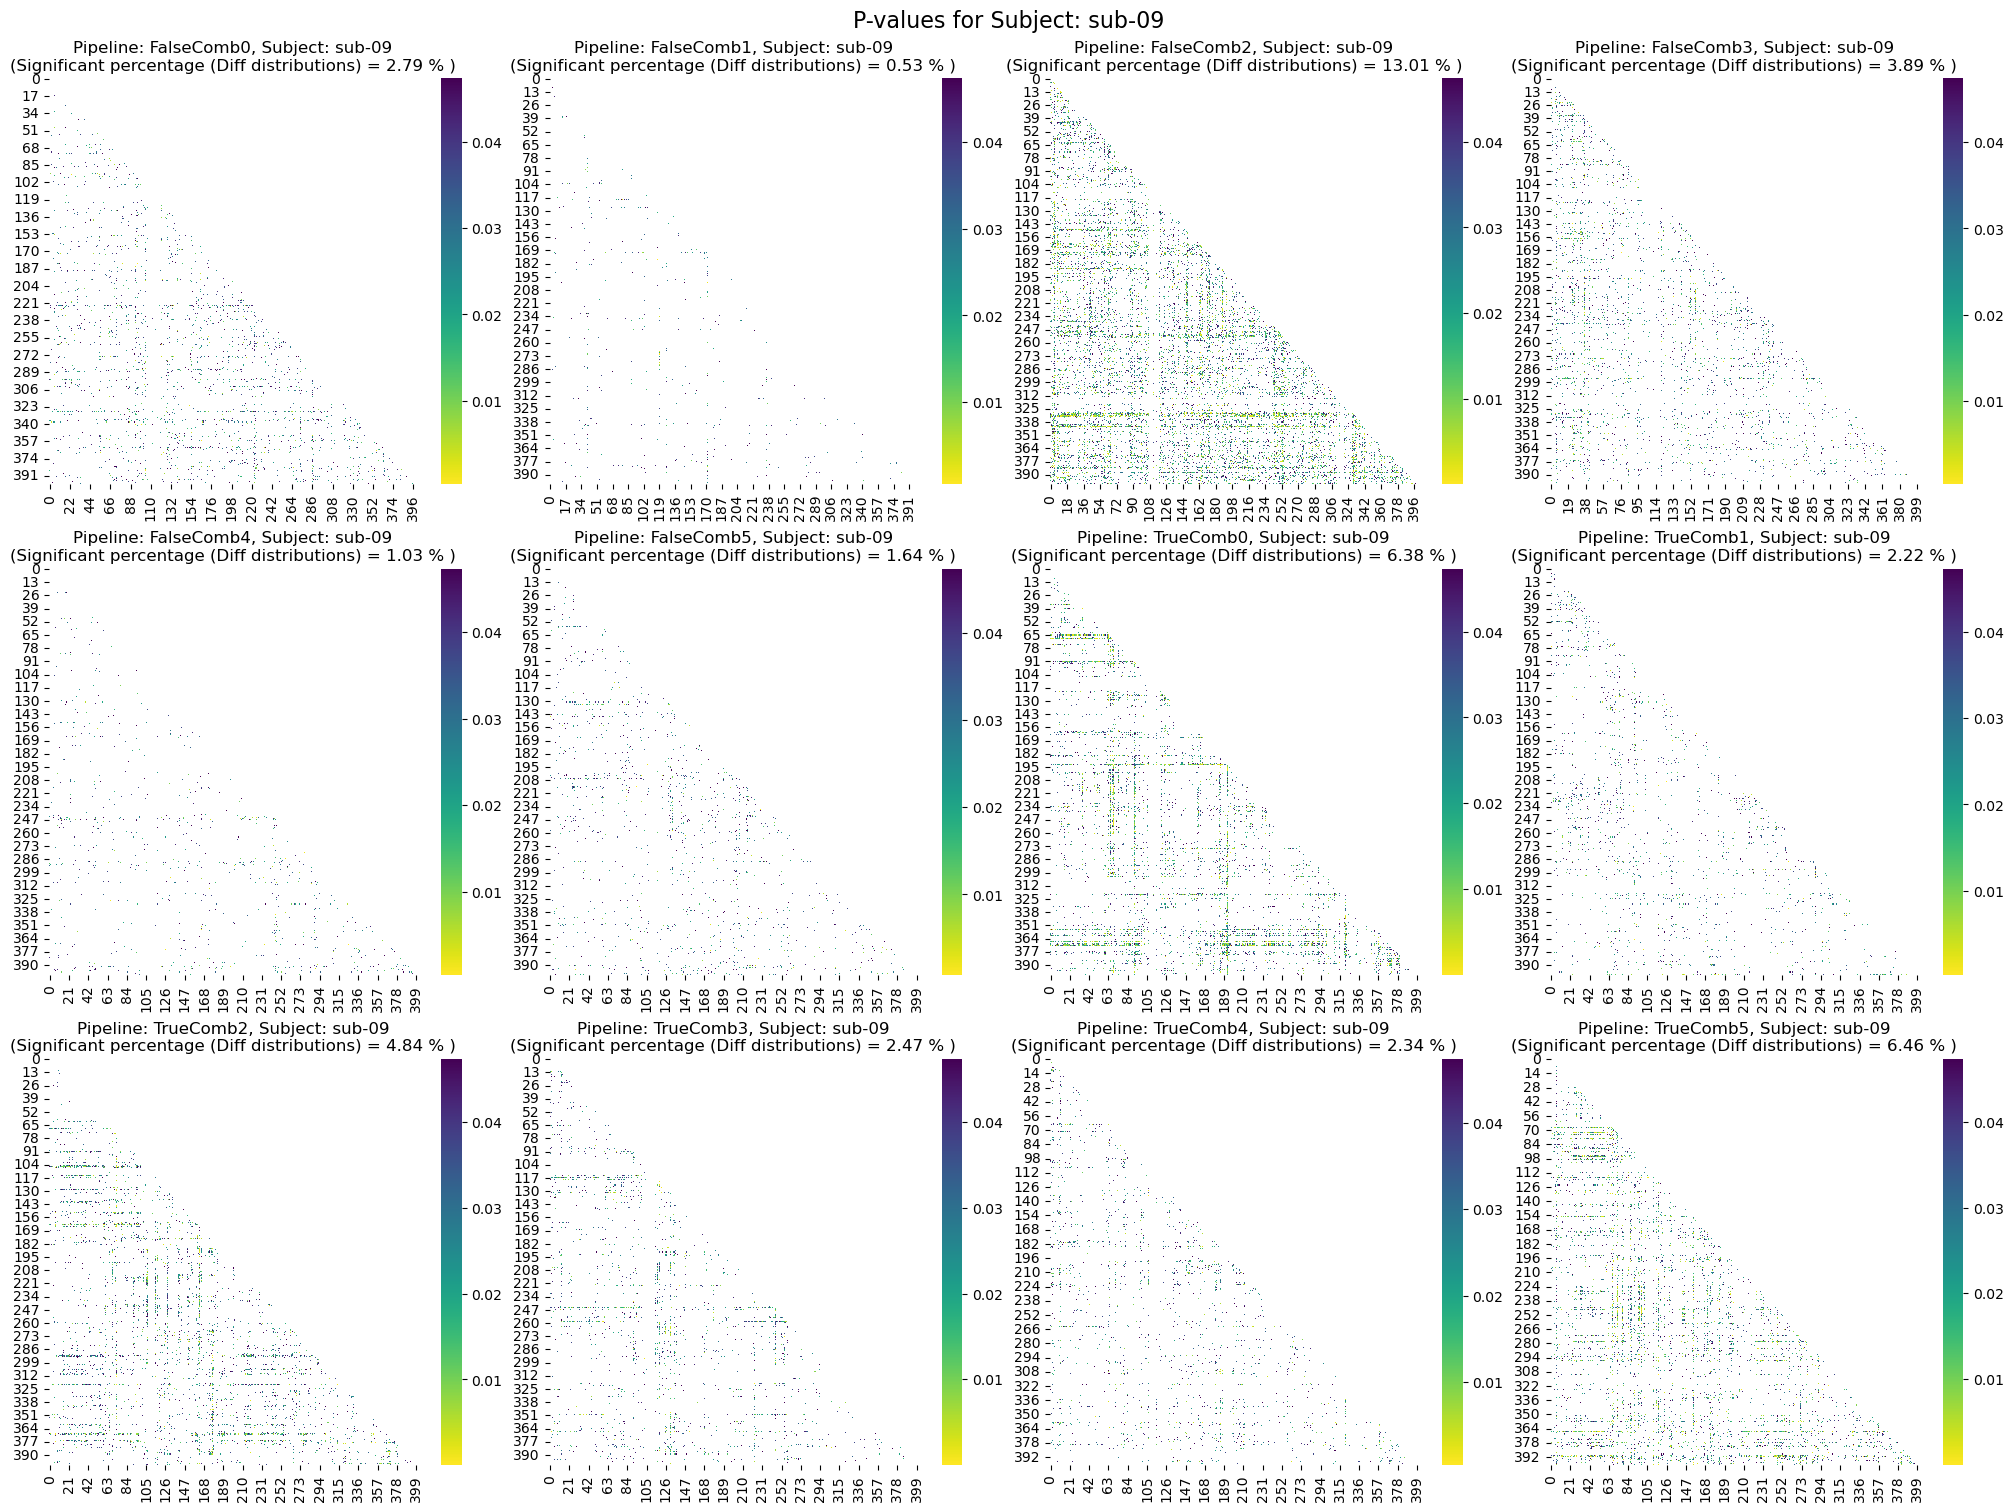

In [36]:
subjects = ds.subject.values
pipelines = ds.pipeline.values

for subject_index in range(len(subjects[:2])):
    subject = subjects[subject_index]
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15), constrained_layout=True)
    
    for pipeline_index in range(len(pipelines)):
        pipeline = pipelines[pipeline_index]
        ax = axes[pipeline_index // 4, pipeline_index % 4]
        plot_p_values(f"Pipeline: {pipeline}, Subject: {subject}", ax, pipeline_index, subject_index)
    
    plt.suptitle(f"P-values for Subject: {subject}", fontsize=16)
    plt.show()